
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>
```
</p>

<a href="https://linkedin.com/lucasvazelle">Vazelle Lucas, Tarverdian Mariam, Vo Nguyen Thao Nhi </a> $\cdot$ 2024-2025, MOSEF $\cdot$ 

---

Times series
- [Import données](https://cds.climate.copernicus.eu/datasets/sis-ocean-wave-timeseries?tab=overview)
- [Documentation Copernicus](https://confluence.ecmwf.int/display/CKB/Product+user+guide+for+sea+level+and+ocean+wave+products+-+time+series+and+indicators)
- Analyse exploratoire
    - Analyse préléminaire, choix d'une série temporelle
    - Analyse saisonnalité
    - Analyse stationnarté faible
- Traitement des tables
    - traitement des variables en degré
    - filtre des données par ondelette
    - gestion des na
    - transformation des fichiers en dataframe


In [42]:
!pip install xarray netcdf4 cartopy plotly statsmodels PyWavelets

In [43]:
import pandas as pd
import netCDF4 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import pywt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf as sm_acf  
from scipy.stats import skew

# Import donnée

Copier le texte ci-dessous, dans le fichier HOME/.cdsapirc (dans votre environnement):
url: https://cds.climate.copernicus.eu/api key: 00bfa379-1ab5-41c1-98ef-4deaa3abfa26

In [44]:
# import cdsapi

# dataset = "sis-ocean-wave-timeseries"
# request = {
#     "variable": [
#         "Mean wave direction",
#         "Mean wave period",
#         "Peak wave period",
#         "Significant wave height"
#     ],
#     "experiment": "ERA5 reanalysis",
#     "year": ["2016", "2017"]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()


In [45]:
informations_vagues_2016_2017_nazare = pd.read_csv("data/donnees_preprocesse_pour_modelisation", sep=",")

# Analyse exploratoire


Locs correspond aux corrdonnées de la station, il y en a près de 8000

station_x_coordinate station_y_coordinate correspondent aux coordonnées latitude et longitude des stations

mp1 (s) : période moyenne des vagues océaniques générées par les vents locaux et la houle. La période des vagues est le temps moyen nécessaire à deux crêtes de vagues consécutives, à la surface de l'océan/de la mer, pour passer par un point fixe

mwd (dégré) : direction moyenne des vagues de surface de l'océan/de la mer générées par les vents locaux et la houle.

pp1d (m) :  la période des vagues océaniques les plus énergétiques générées par les vents et la houle local

swh (m):  hauteur moyenne du tiers le plus élevé des vagues de surface de l'océan/de la mer générées par le vent et la houle. Il représente la distance verticale entre la crête et le creux de la vague. 

## Exploration préliminaire

In [46]:
#data_folder = "data/data_collect" #(Pour Nhi)
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [47]:
import xarray as xr
ds = xr.open_dataset(netcdf_files[2])
ds


<xarray.Dataset>
Dimensions:               (scalar: 1, time: 8784, locs: 7708)
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:...
    station_x_coordinate  (locs) float64 ...
    station_y_coordinate  (locs) float64 ...
Dimensions without coordinates: scalar, locs
Data variables:
    missing_value         (scalar) float64 ...
    mwd                   (time, locs) float64 ...
Attributes: (12/18)
    title:                SAW ERA5 - MWD
    institution:          Deltares, www.deltares.nl
    project:              C3S_422_Lot2 Deltares
    geospatial_lon_min:   43.6
    geospatial_lat_max:   79.1
    time_coverage_end:    
    ...                   ...
    licence:              
    keywords:             waves, future climate runs, historical climate runs...
    summary:              wave parameters at locations along 20-m depth line ...
    geospatial_lon_max:   322.1
    history:              Wed Mar 20 15:57:24 2019: ncatted -a standard_name,...
    NCO:                  netCDF Operators version 4.7.8 (Homepage = http://n...

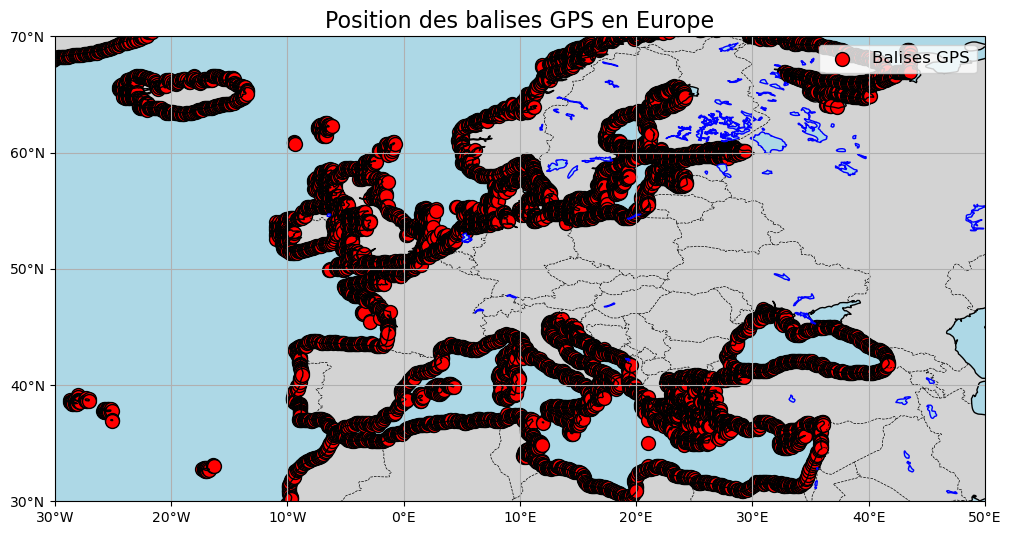

In [48]:
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur l'Europe (limites : longitude et latitude)
ax.set_extent([-30, 50, 30, 70], crs=ccrs.PlateCarree())  # Europe et alentours

ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')  # Lacs

# Tracer les positions des balises
sc = ax.scatter(longitude, latitude, s=100, color='red', edgecolor='k', transform=ccrs.PlateCarree(), label='Balises GPS')

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter une grille de latitude et longitude
ax.grid(True)  # Afficher la grille
ax.set_xticks(range(-30, 51, 10))  # Plages de longitude (modifiables)
ax.set_yticks(range(30, 71, 10))  # Plages de latitude (modifiables)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# # Afficher les numéros pour certaines balises seulement
# for i, (lon, lat) in enumerate(zip(longitude, latitude)):
#     # Condition : Afficher les numéros des balises uniquement pour des coordonnées spécifiques
#     if -30 <= lon <= 70 and -10 <= lat <= 70:  # Exemple : afficher les numéros pour ces régions géographiques
#         ax.text(lon, lat, str(i), fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree())

ax.set_title('Position des balises GPS en Europe', fontsize=16)

plt.show()


c:\Users\vongu\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:856: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.set_xlim([x1, x2])
c:\Users\vongu\anaconda3\Lib\site-packages\cartopy\mpl\geoaxes.py:857: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.set_ylim([y1, y2])


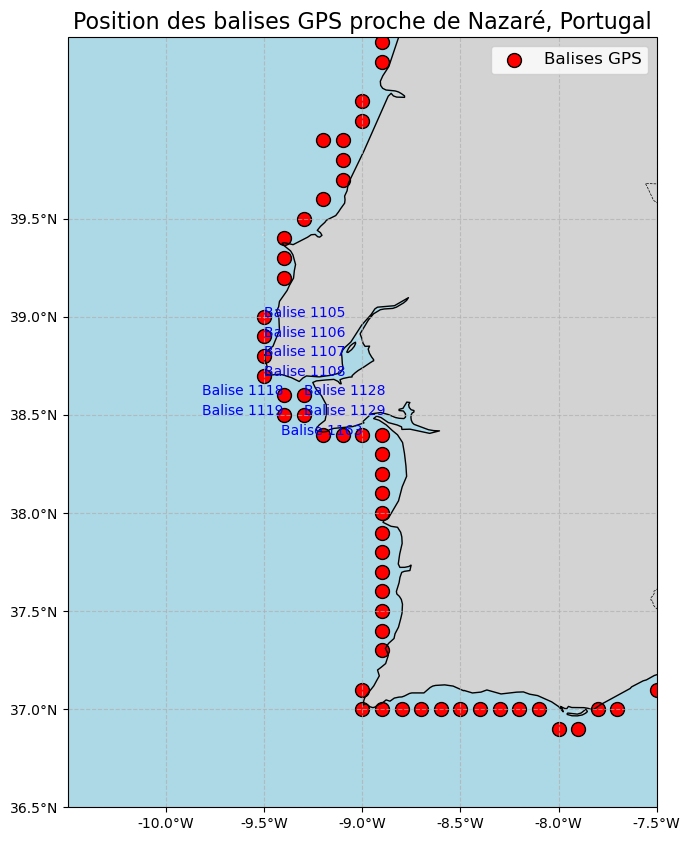

In [49]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np  # Assurez-vous que cette bibliothèque est importée

# Extraire les coordonnées des stations et leur identifiant "locs"
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values
locs = ds['locs'].values  # Identifiants des balises

# Créer une figure avec une projection géographique
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur la région élargie autour de Nazaré
ax.set_extent([-10.0, -10.0, 38.5, 38.5], crs=ccrs.PlateCarree())

# Ajouter des fonds de carte
ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')  # Lacs

# Filtrer uniquement les points où un "locs" est défini
valid_indices = ~np.isnan(locs)  # Identifie les balises avec un locs non-NaN
filtered_longitude = longitude[valid_indices]
filtered_latitude = latitude[valid_indices]
filtered_locs = locs[valid_indices]

# Tracer les positions des balises filtrées
sc = ax.scatter(
    filtered_longitude, filtered_latitude, 
    s=100, color='red', edgecolor='k', 
    transform=ccrs.PlateCarree(), label='Balises GPS'
)

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')
for lon, lat, loc in zip(filtered_longitude, filtered_latitude, filtered_locs):
    if  (1105<= loc <= 1108) or   (loc ==1129)or (loc ==1128):
        ax.text(
            lon, lat,
            f"Balise {int(loc)}",
            fontsize=10, ha='left', color='blue', transform=ccrs.PlateCarree()
        )

for lon, lat, loc in zip(filtered_longitude, filtered_latitude, filtered_locs):
    if  (1118<= loc <= 1119) or (loc ==1163):
        ax.text(
            lon, lat,
            f"Balise {int(loc)}",
            fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree()
        )
# for lon, lat, loc in zip(filtered_longitude, filtered_latitude, filtered_locs):
#     if   (loc ==1150) or (loc ==1139):
#         ax.text(
#             lon, lat,
#             f"Balise {int(loc)}",
#             fontsize=10, ha='left', color='blue', transform=ccrs.PlateCarree()
#         )


# Ajouter une grille de latitude et longitude
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_xticks(np.arange(-10.0, -7, 0.5))  # Plages de longitude
ax.set_yticks(np.arange(36.5, 40, 0.5))  # Plages de latitude
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# Ajouter un titre
ax.set_title('Position des balises GPS proche de Nazaré, Portugal', fontsize=16)

plt.show()


## choix balise et fusion des tables 2016 et 2017 

In [50]:
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]
numero_balise = 1128 # nazaré

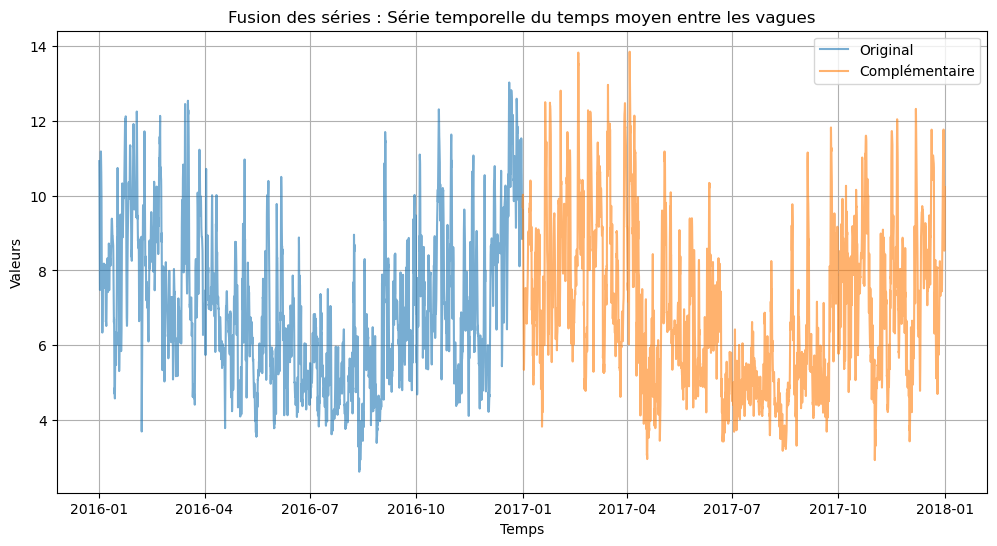

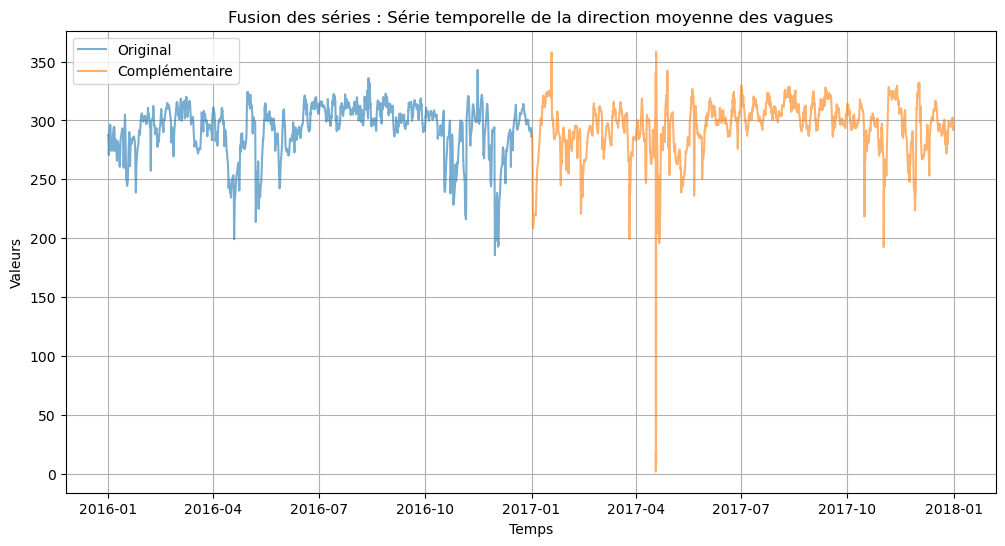

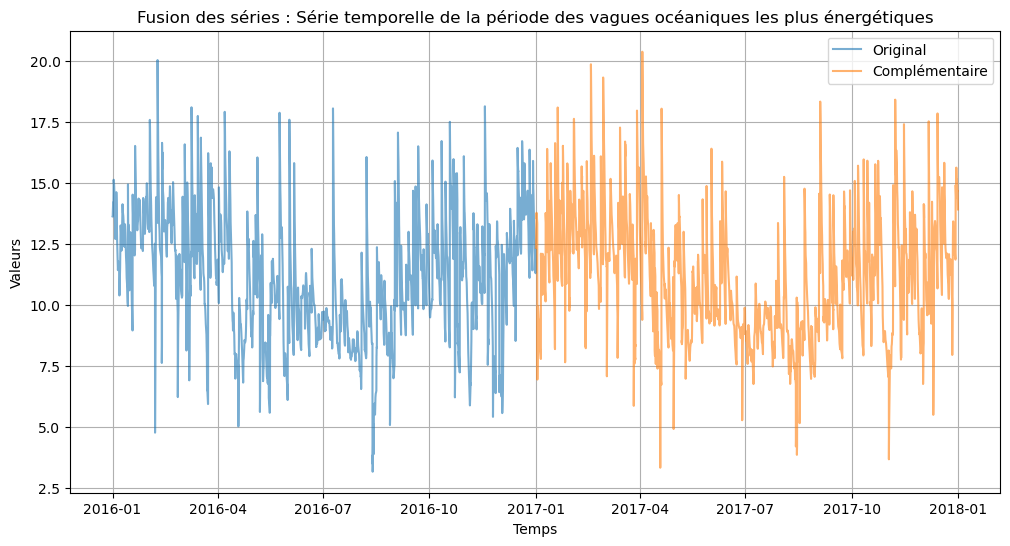

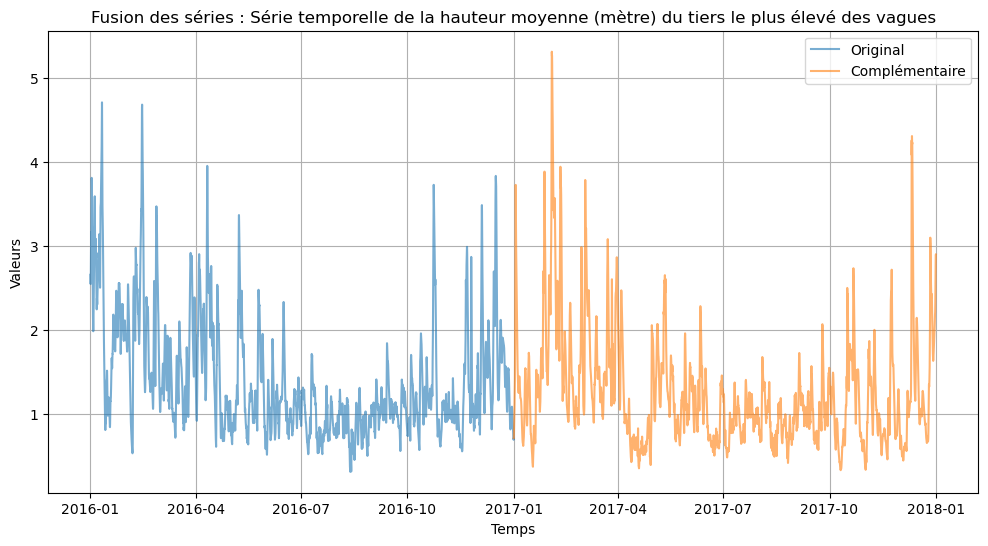

In [51]:
temps_moyen_entre_les_vagues_2016_nazare = xr.open_dataset(netcdf_files[0])['mp1'].isel(locs=numero_balise)
direction_moyene_des_vagues_2016_nazare  = xr.open_dataset(netcdf_files[2])['mwd'].isel(locs=numero_balise)
temps_moyen_entre_les_vagues_energetiques_2016_nazare = xr.open_dataset(netcdf_files[4])['pp1d'].isel(locs=numero_balise)
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_nazare  = xr.open_dataset(netcdf_files[6])['swh'].isel(locs=numero_balise)
tables_2016 = [
    temps_moyen_entre_les_vagues_2016_nazare ,
    direction_moyene_des_vagues_2016_nazare ,
    temps_moyen_entre_les_vagues_energetiques_2016_nazare ,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_nazare 
]

temps_moyen_entre_les_vagues_2017_nazare  = xr.open_dataset(netcdf_files[1])['mp1'].isel(locs=numero_balise)
direction_moyene_des_vagues_2017_nazare  = xr.open_dataset(netcdf_files[3])['mwd'].isel(locs=numero_balise)
temps_moyen_entre_les_vagues_energetiques_2017_nazare  = xr.open_dataset(netcdf_files[5])['pp1d'].isel(locs=numero_balise)
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017_nazare  = xr.open_dataset(netcdf_files[7])['swh'].isel(locs=numero_balise)

# Listes des séries temporelles originales et complémentaires
tables_2017 =[
    temps_moyen_entre_les_vagues_2017_nazare ,
    direction_moyene_des_vagues_2017_nazare ,
    temps_moyen_entre_les_vagues_energetiques_2017_nazare ,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017_nazare
]

titles = [
    "Série temporelle du temps moyen entre les vagues",
    "Série temporelle de la direction moyenne des vagues",
    "Série temporelle de la période des vagues océaniques les plus énergétiques",
    "Série temporelle de la hauteur moyenne (mètre) du tiers le plus élevé des vagues"
]

merged_table_names = [
    "temps_moyen_entre_les_vagues_2016_2017_nazare ",
    "direction_moyene_des_vagues_2016_2017_nazare ",
    "temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare ",
    "hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare "
]

# Concaténer les DataArrays pour chaque variable
temps_moyen_entre_les_vagues_2016_2017_nazare = xr.concat([tables_2016[0], tables_2017[0]], dim="time")
direction_moyene_des_vagues_2016_2017_nazare = xr.concat([tables_2016[1], tables_2017[1]], dim="time")
temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare = xr.concat([tables_2016[2], tables_2017[2]], dim="time")
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare = xr.concat([tables_2016[3], tables_2017[3]], dim="time")

# Initialiser le dictionnaire final et la liste des tables fusionnées

merged_tables_list = [temps_moyen_entre_les_vagues_2016_2017_nazare,
direction_moyene_des_vagues_2016_2017_nazare,
temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare ,
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare]

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

# Fusion des tables originales avec les complémentaires
for name, original, complementaire, title in zip(titles, tables_2016, tables_2017, titles):
  
    # Visualisation de la fusion pour vérification
    plt.figure(figsize=(12, 6))
    plt.plot(original["time"], original.values, label="Original", alpha=0.6)
    plt.plot(complementaire["time"], complementaire.values, label="Complémentaire", alpha=0.6)
    plt.title(f"Fusion des séries : {title}")
    plt.xlabel("Temps")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid()
    plt.show()


## Graphique des séries

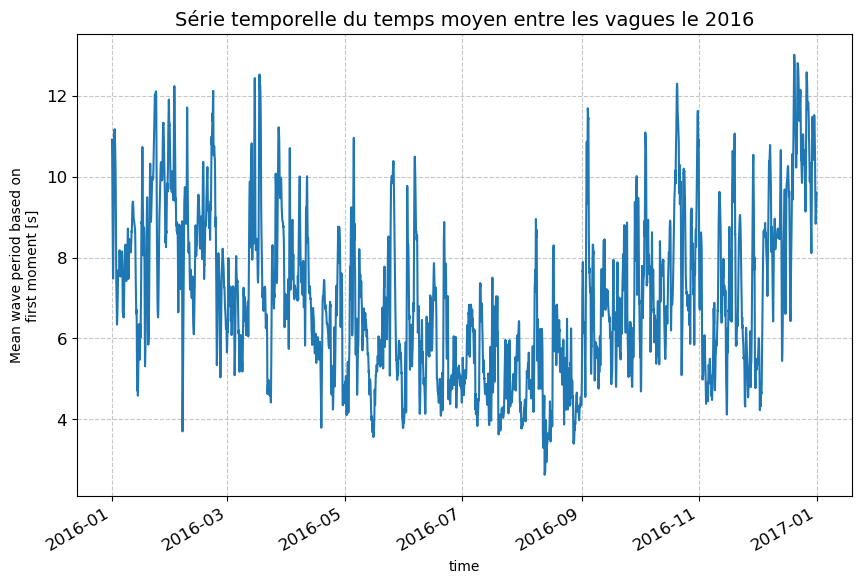

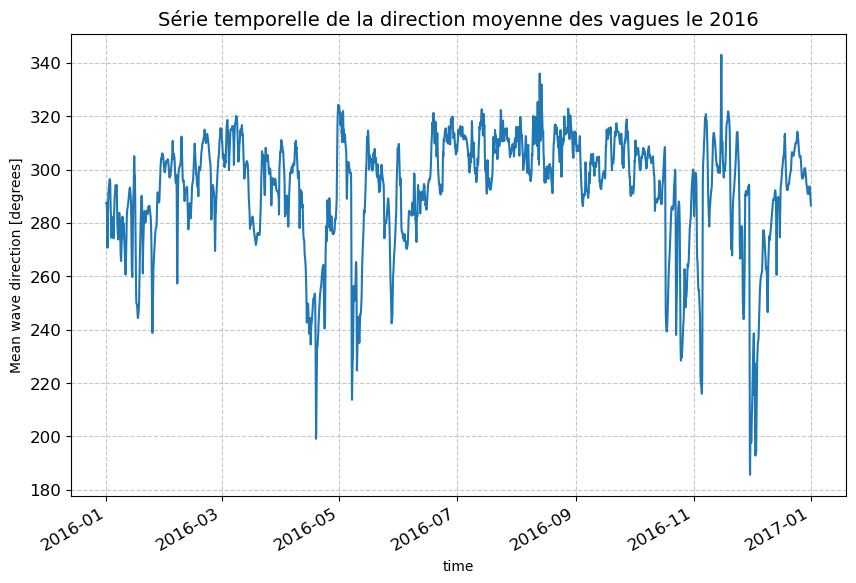

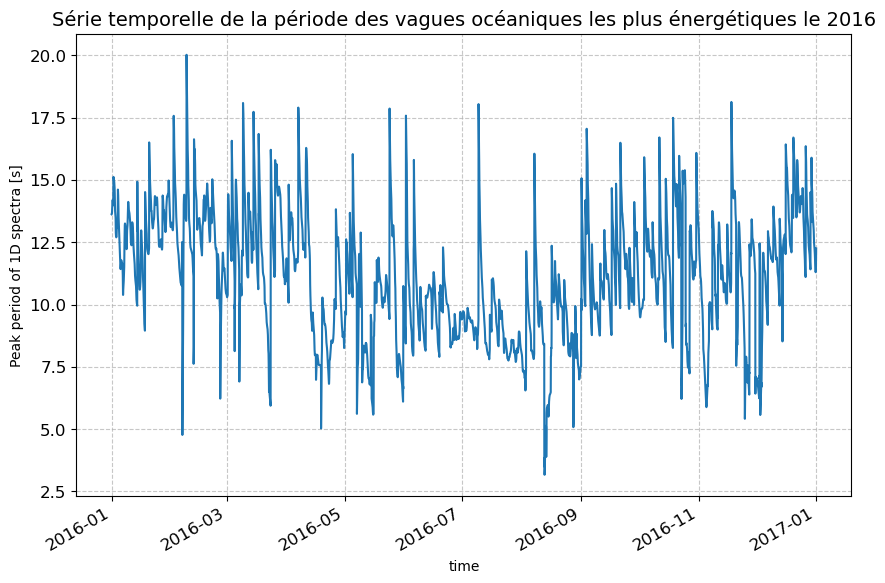

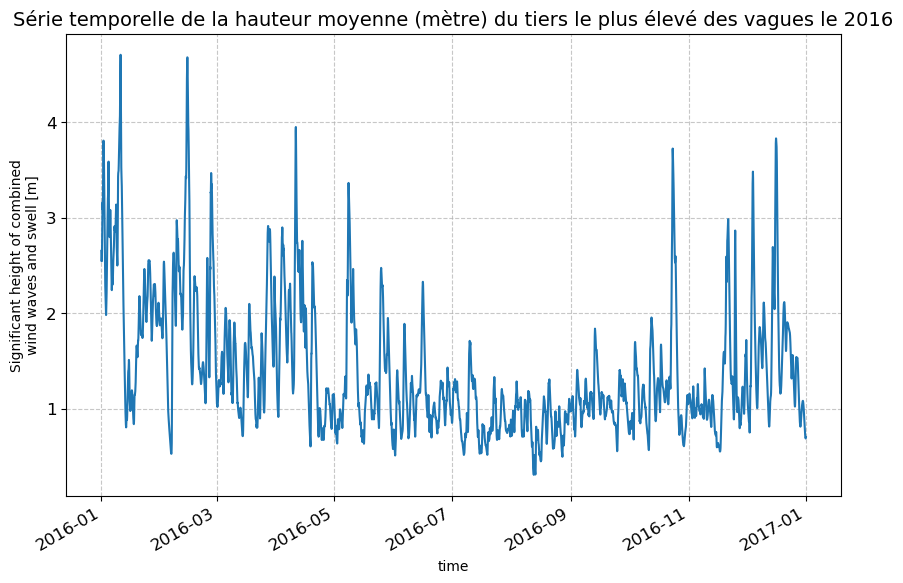

In [52]:
date_filtre = "2016"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()


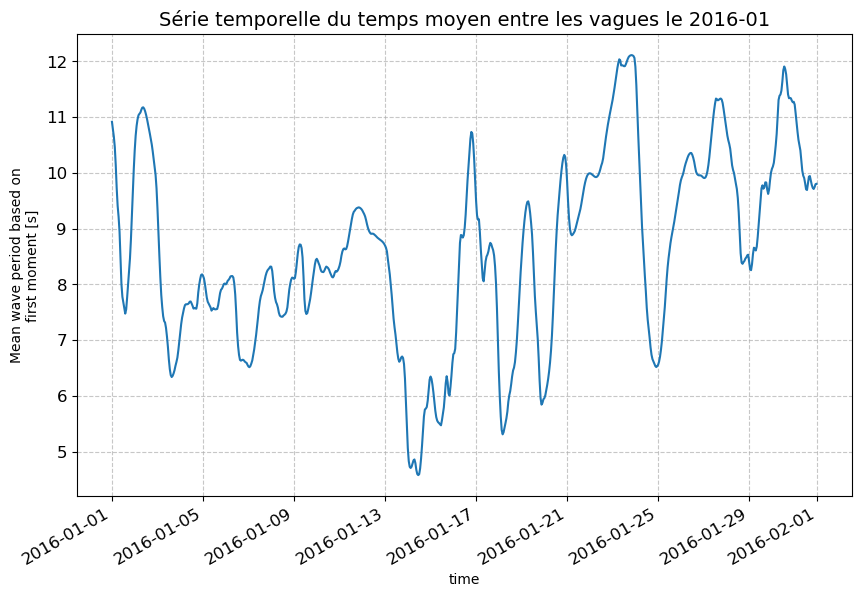

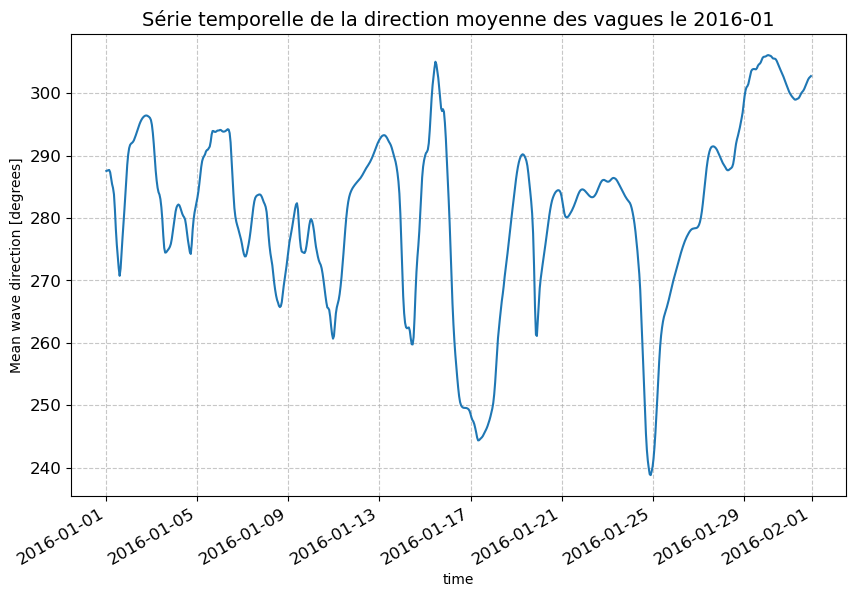

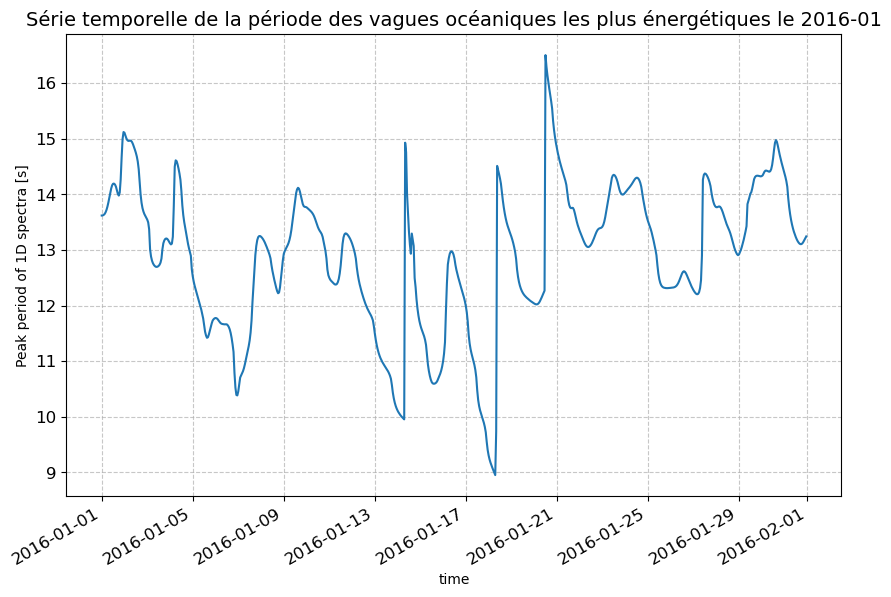

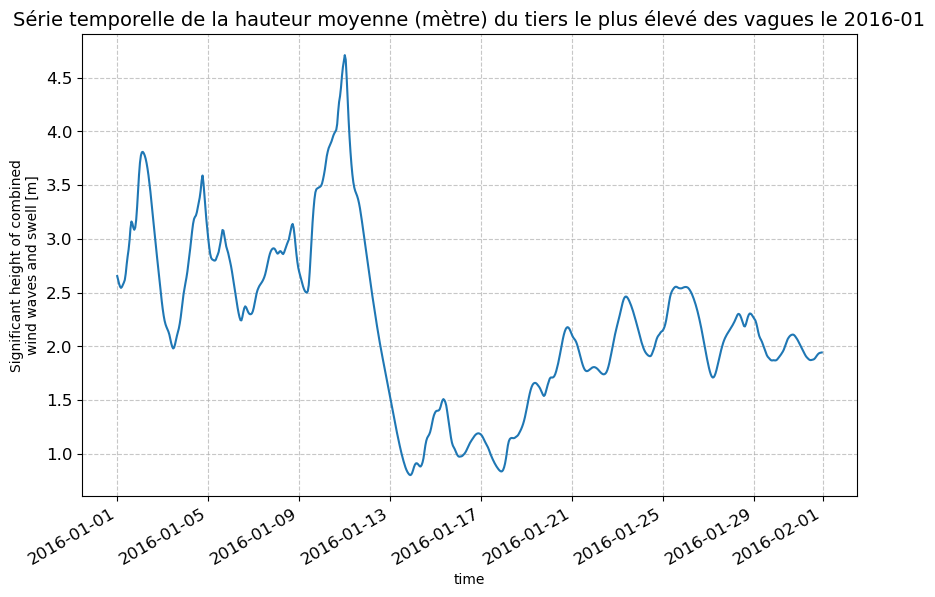

In [53]:
date_filtre = "2016-01"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()

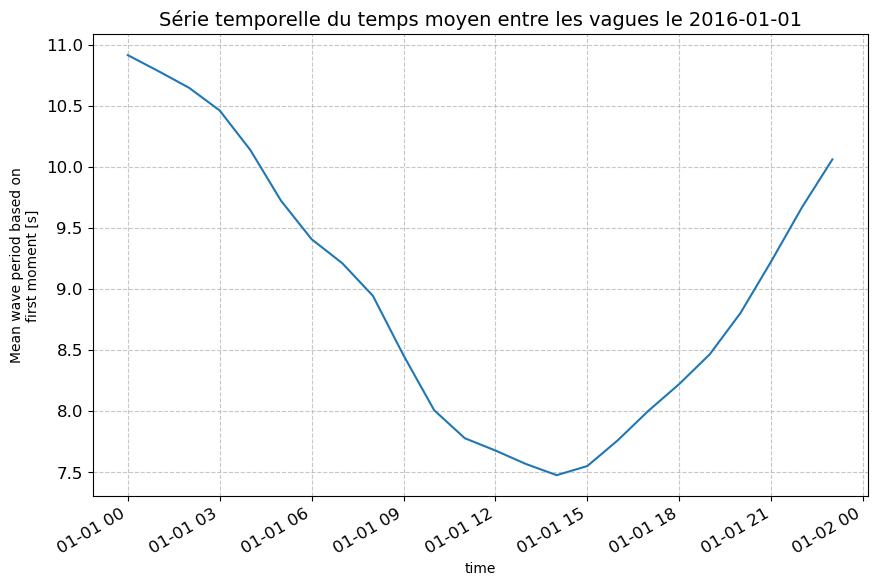

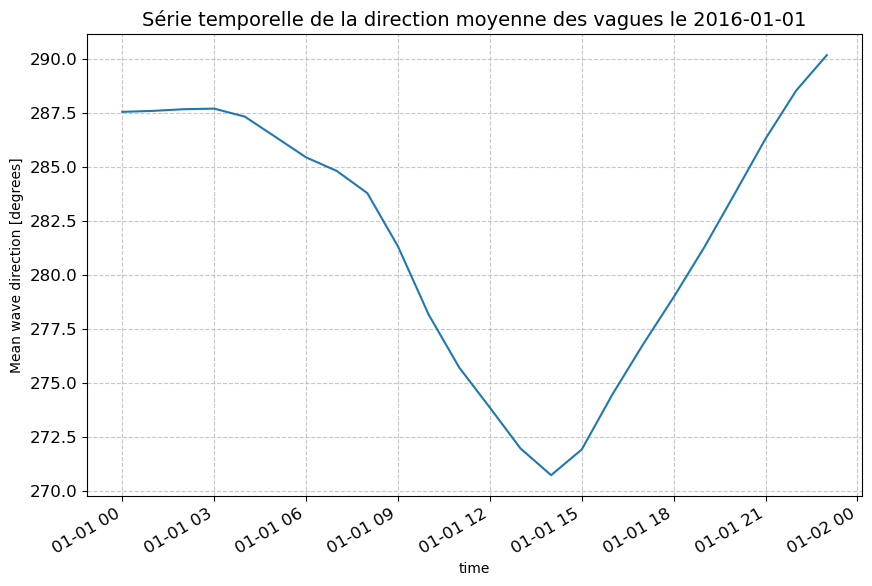

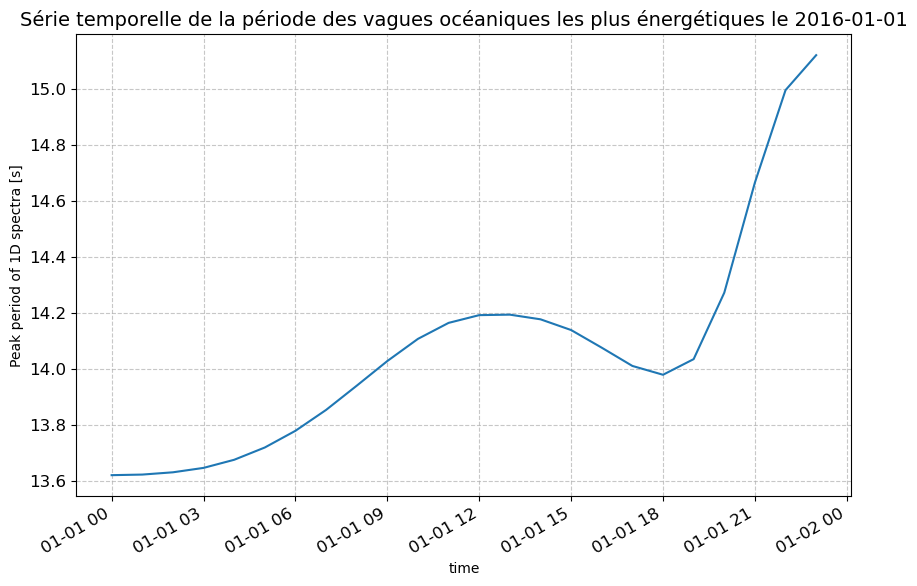

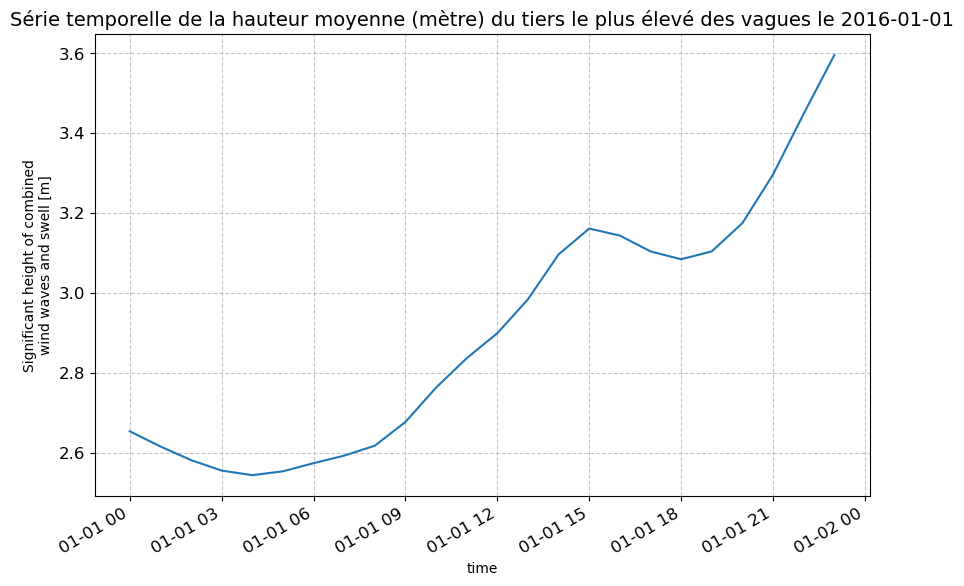

In [54]:
date_filtre = "2016-01-01"
for table, title in zip(merged_tables_list, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()

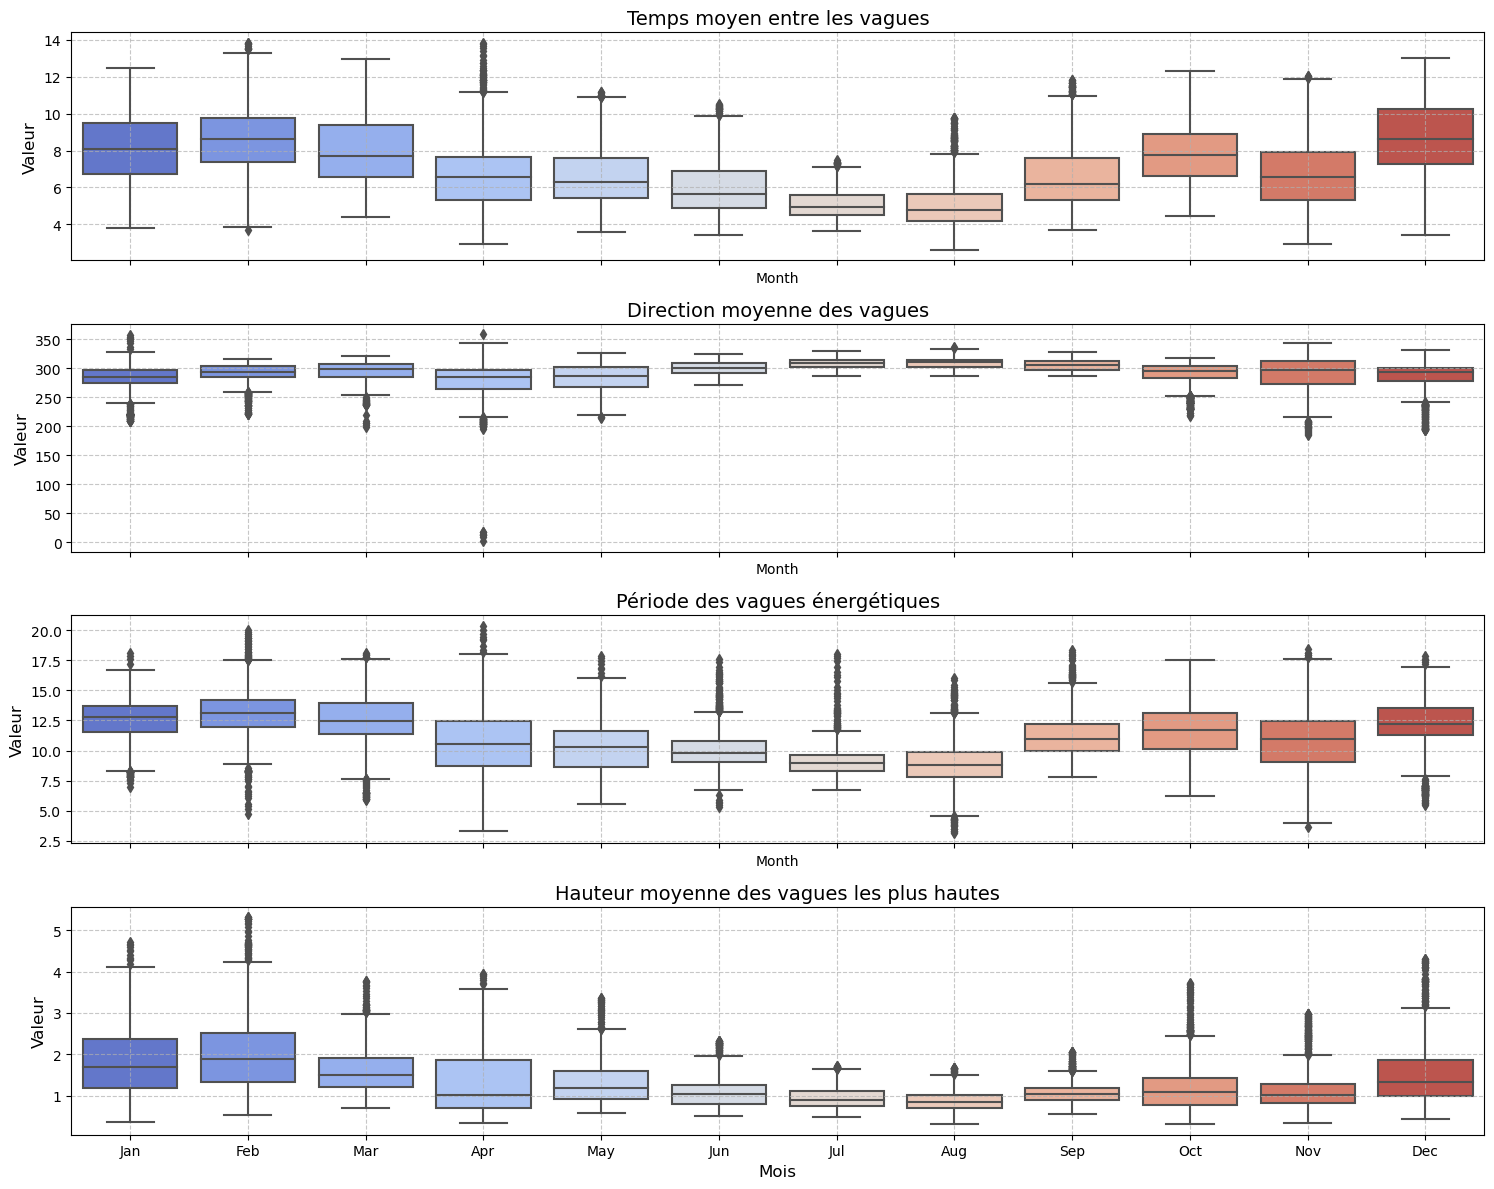

In [55]:

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

data_list = []
for name, data in tables.items():
    df = pd.DataFrame({
        "time": data["time"].values,
        "value": data.values,
        "variable": name
    })
    df["Month"] = pd.to_datetime(df["time"]).dt.strftime("%b")  # Extraire le mois
    data_list.append(df)

all_data = pd.concat(data_list, ignore_index=True)

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axes = plt.subplots(len(tables), 1, figsize=(15, 12), sharex=True)

for (name, ax) in zip(tables.keys(), axes):
    sns.boxplot(
        data=all_data[all_data["variable"] == name],
        x="Month", y="value",
        ax=ax, order=month_order, palette="coolwarm"
    )
    ax.set_ylabel("Valeur", fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Mois", fontsize=12)

plt.tight_layout()
plt.show()


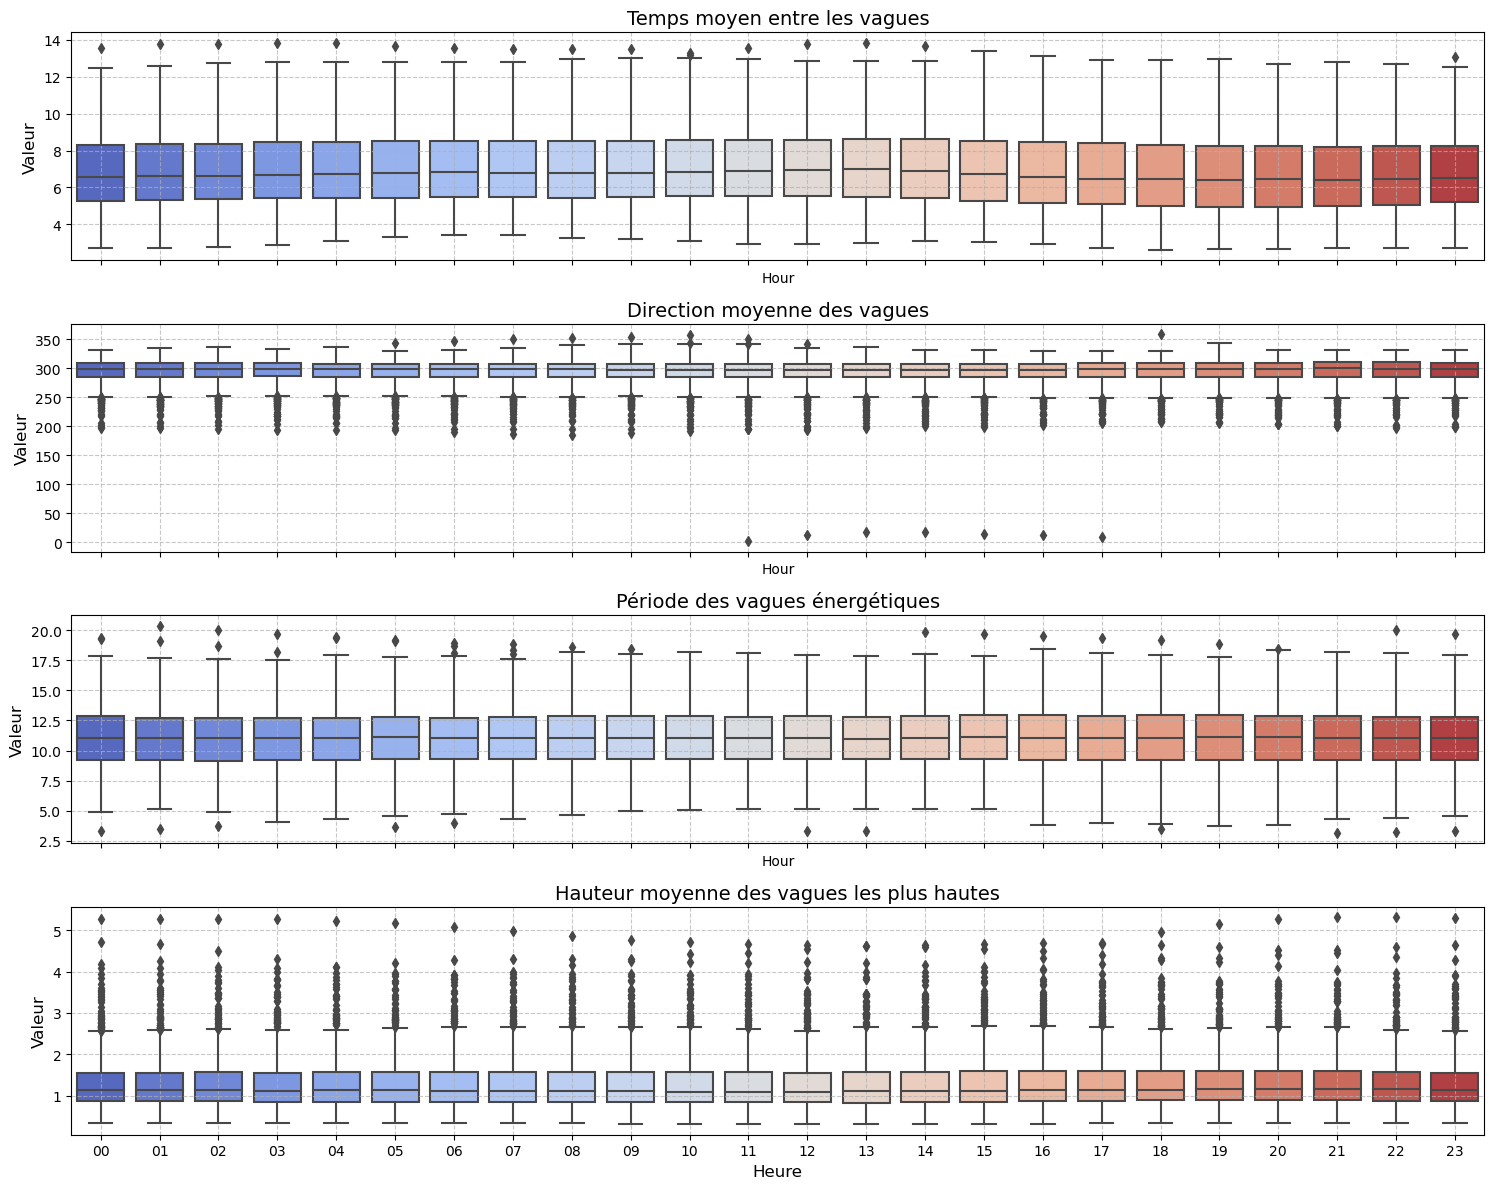

<Figure size 640x480 with 0 Axes>

In [56]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}


data_list = []
for name, data in tables.items():
    df = pd.DataFrame({
        "time": data["time"].values,
        "value": data.values,
        "variable": name
    })
    # Extraire l'heure
    df["Hour"] = pd.to_datetime(df["time"]).dt.strftime("%H")  
    data_list.append(df)

# Combiner toutes les données
all_data = pd.concat(data_list, ignore_index=True)

# Ordre des heures (de 00 à 23)
hour_order = [f"{hour:02}" for hour in range(24)]

# Création des sous-graphiques
fig, axes = plt.subplots(len(tables), 1, figsize=(15, 12), sharex=True)

for (name, ax) in zip(tables.keys(), axes):
    sns.boxplot(
        data=all_data[all_data["variable"] == name],
        x="Hour", y="value",
        ax=ax, order=hour_order, palette="coolwarm"
    )
    ax.set_ylabel("Valeur", fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Heure", fontsize=12)


plt.tight_layout()
plt.show()

plt.savefig("output/boxplot_données_par_heures.png", dpi=300)



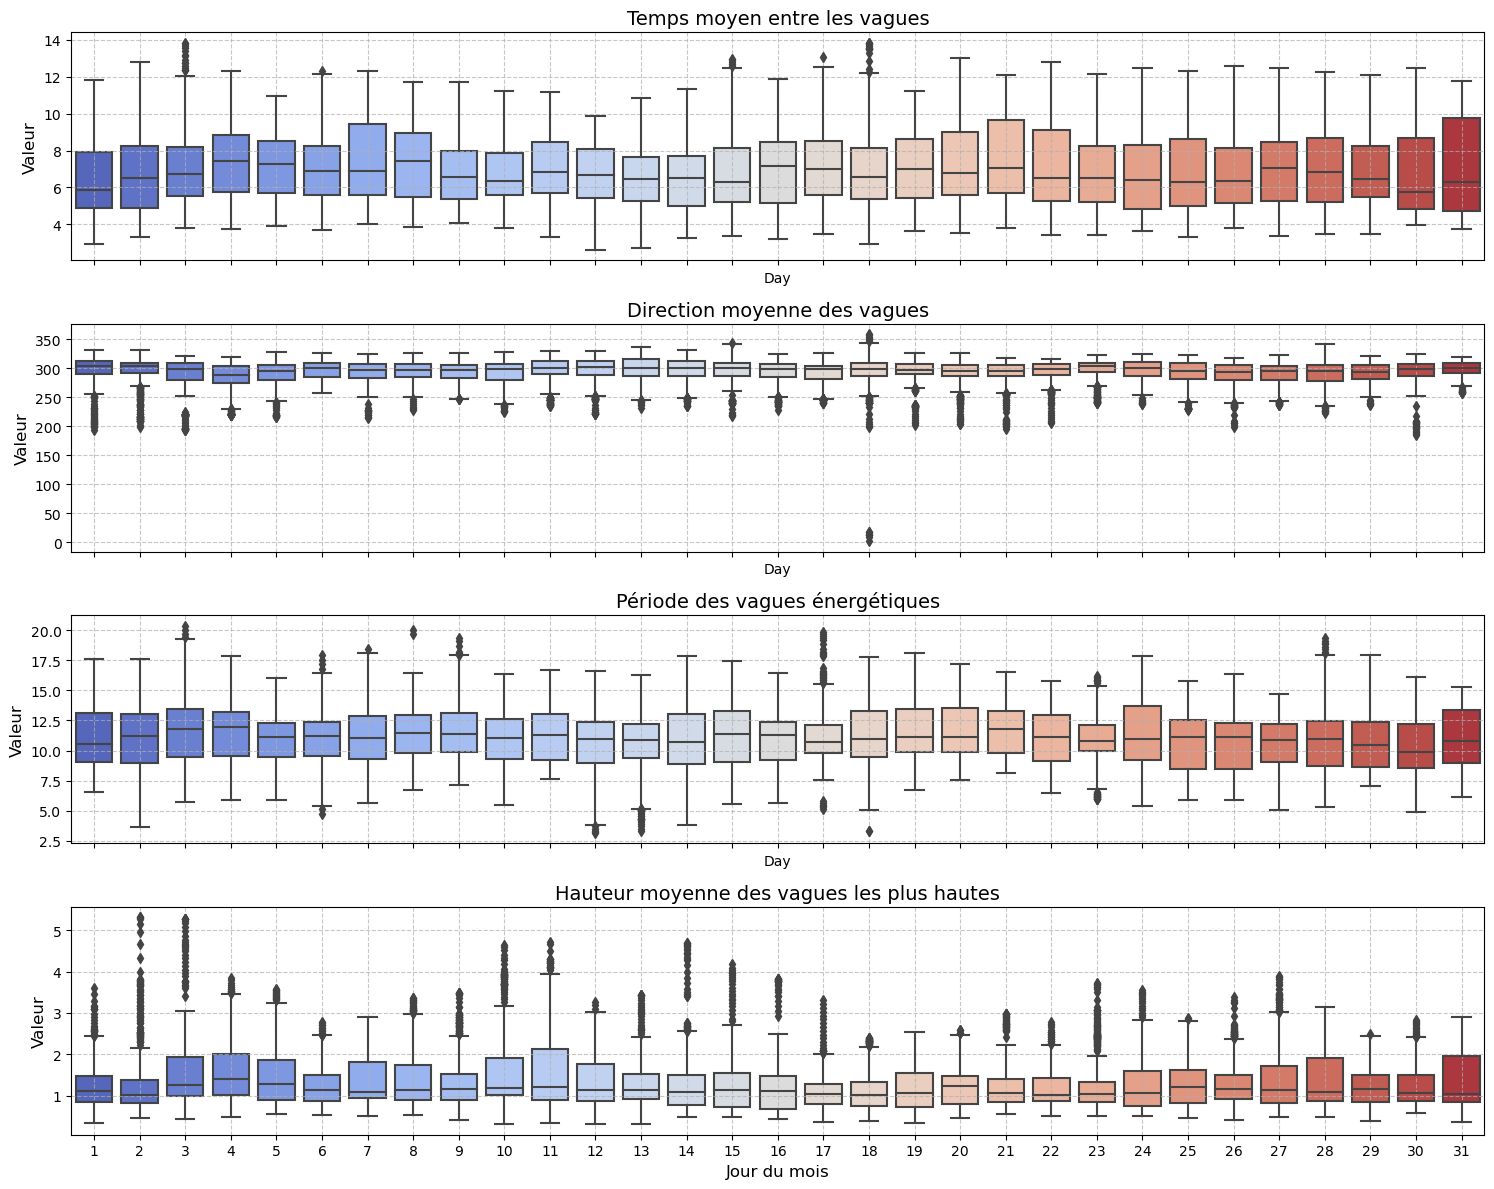

<Figure size 640x480 with 0 Axes>

In [57]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

data_list = []
for name, data in tables.items():
    df = pd.DataFrame({
        "time": data["time"].values,
        "value": data.values,
        "variable": name
    })
    # Extraire le jour du mois
    df["Day"] = pd.to_datetime(df["time"]).dt.day  
    data_list.append(df)

# Combiner toutes les données
all_data = pd.concat(data_list, ignore_index=True)

# Ordre des jours (de 1 à 31)
day_order = list(range(1, 32))

# Création des sous-graphiques
fig, axes = plt.subplots(len(tables), 1, figsize=(15, 12), sharex=True)

for (name, ax) in zip(tables.keys(), axes):
    sns.boxplot(
        data=all_data[all_data["variable"] == name],
        x="Day", y="value",
        ax=ax, order=day_order, palette="coolwarm"
    )
    ax.set_ylabel("Valeur", fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Jour du mois", fontsize=12)

plt.tight_layout()
plt.show()
plt.savefig("output/boxplot_données_par_jours.png", dpi=300)


## Analyse de la saisonnalité

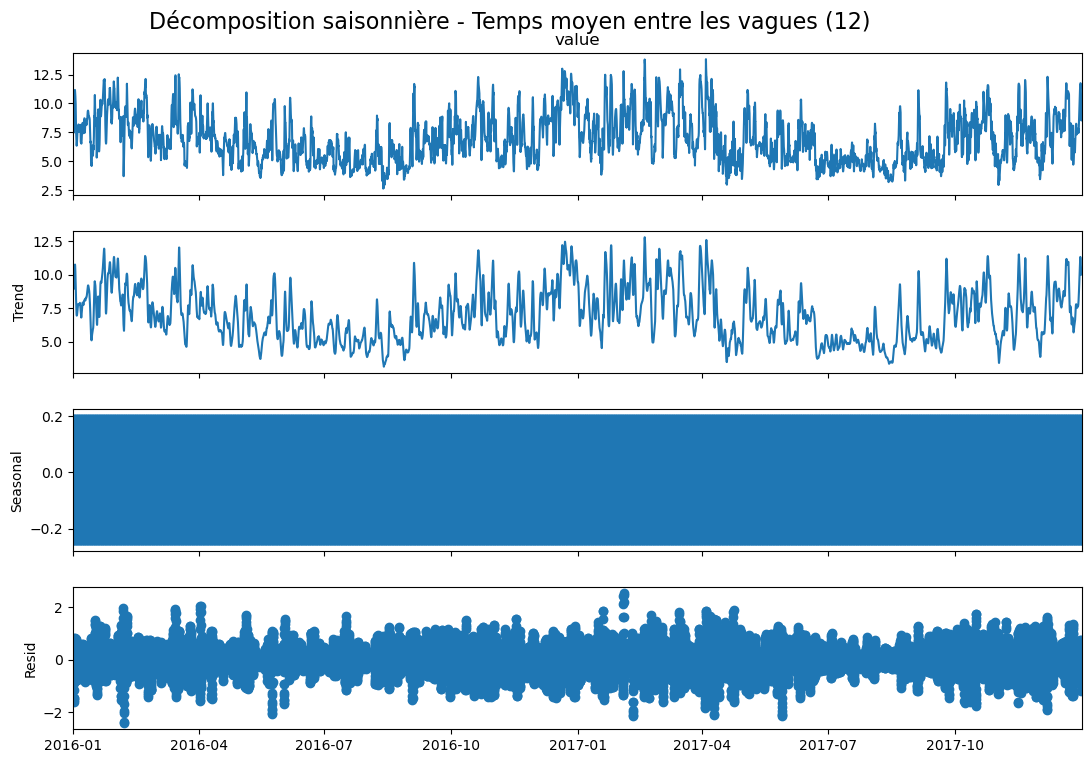

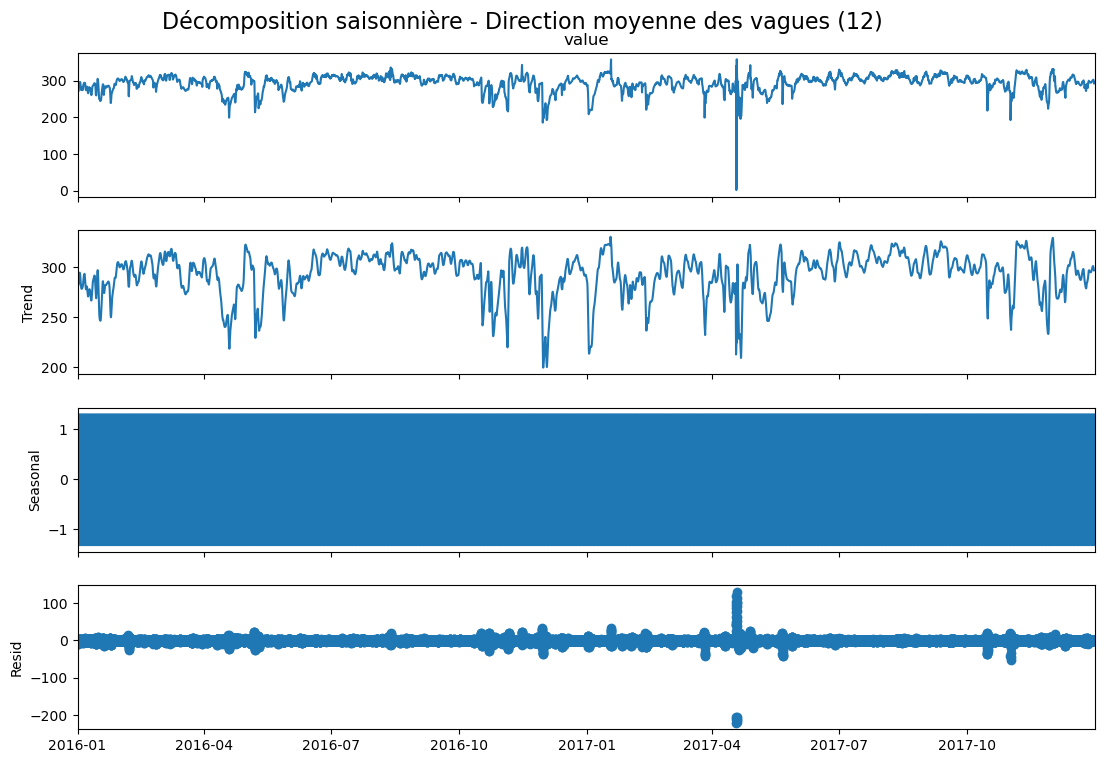

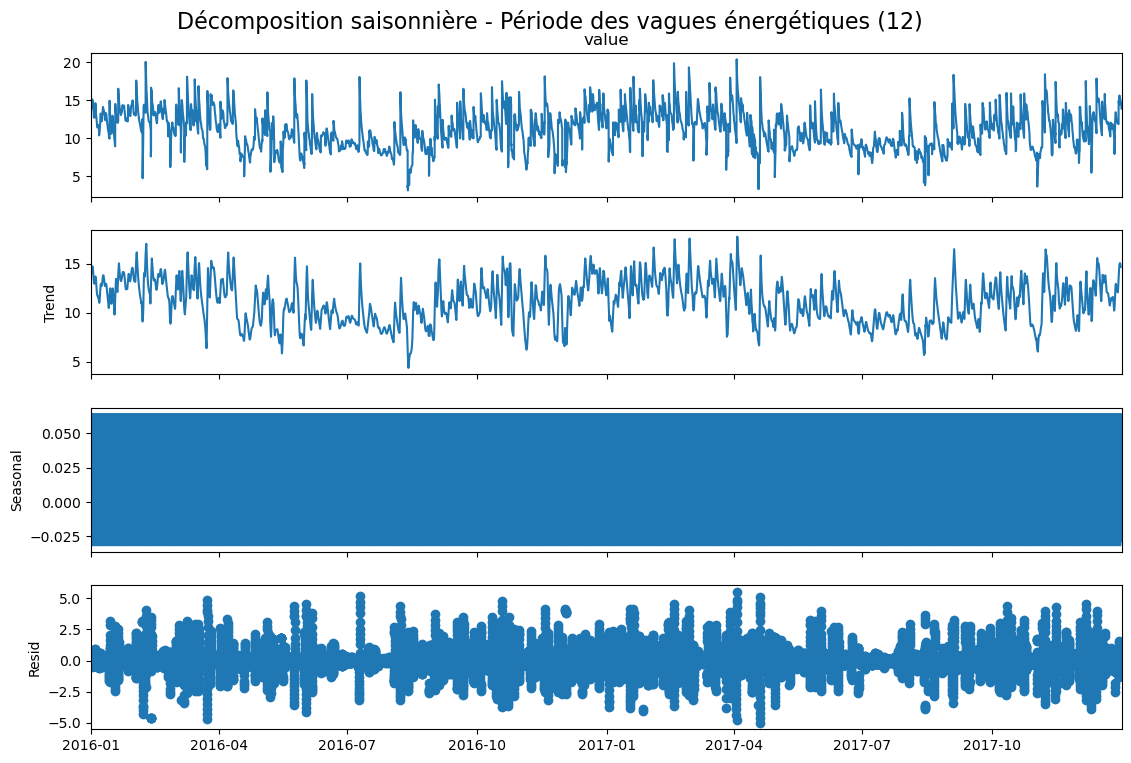

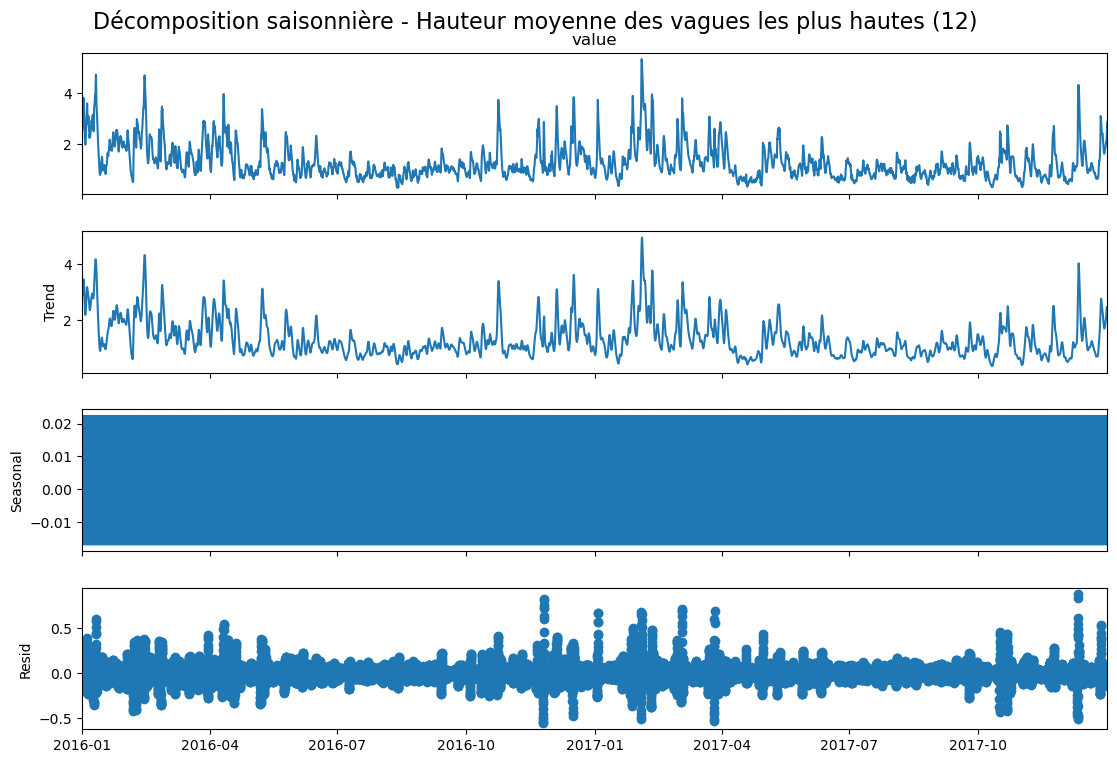

In [58]:

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}
mois_filtre = 12

for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    
    # Vérifier qu'il y a des données après filtrage
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name} en {mois_filtre}.")
        continue
    
    # Effectuer la décomposition saisonnière
    decomposition = seasonal_decompose(df["value"], model="additive", period=24)  # Période = 24 heures (ajustable)
    
    # Tracer le résultat
    fig = decomposition.plot()
    fig.suptitle(f"Décomposition saisonnière - {name} ({mois_filtre})", fontsize=16)  # Ajouter un titre
    fig.set_size_inches(12, 8)  # Ajuster la taille du graphique
    plt.show()

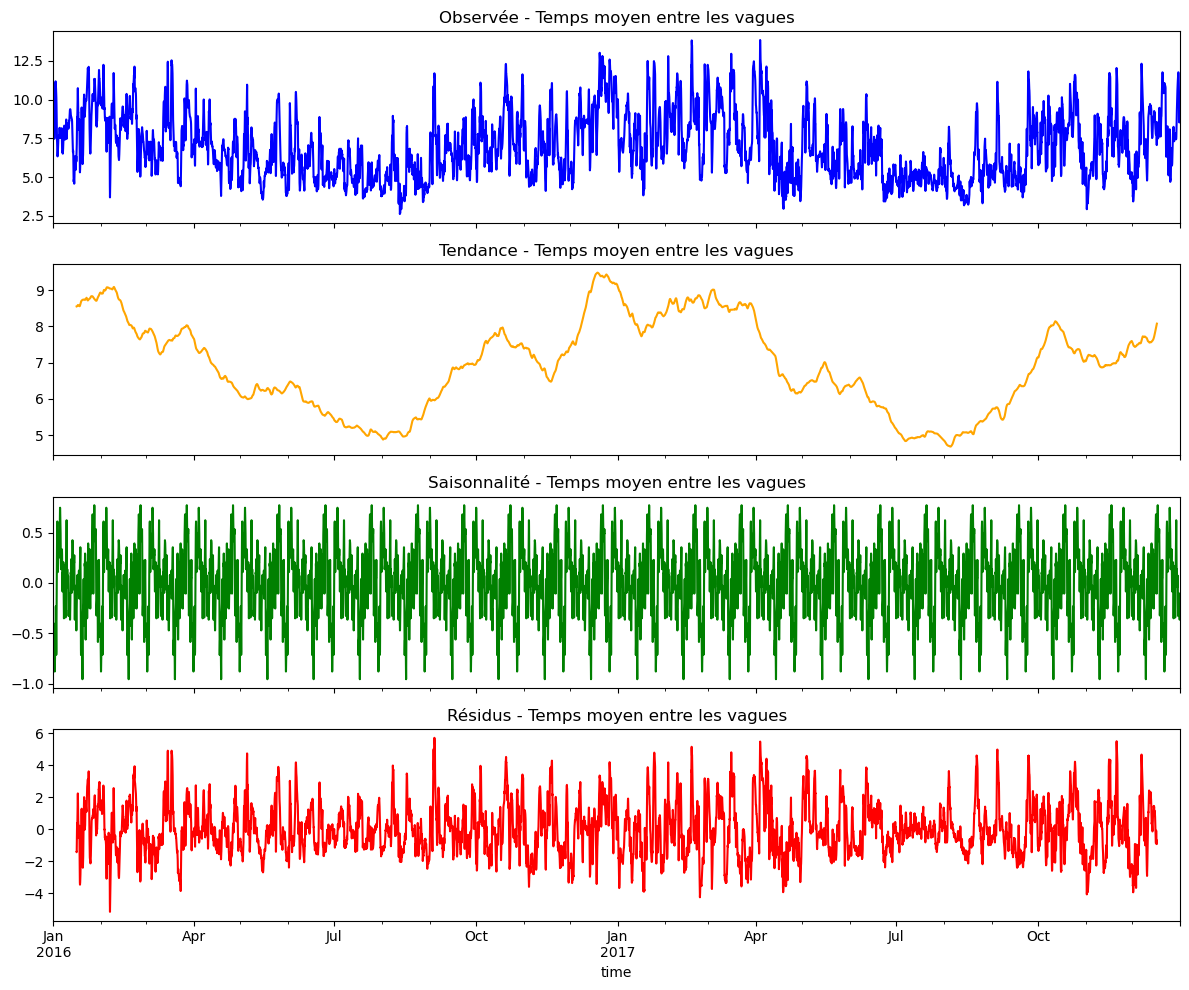

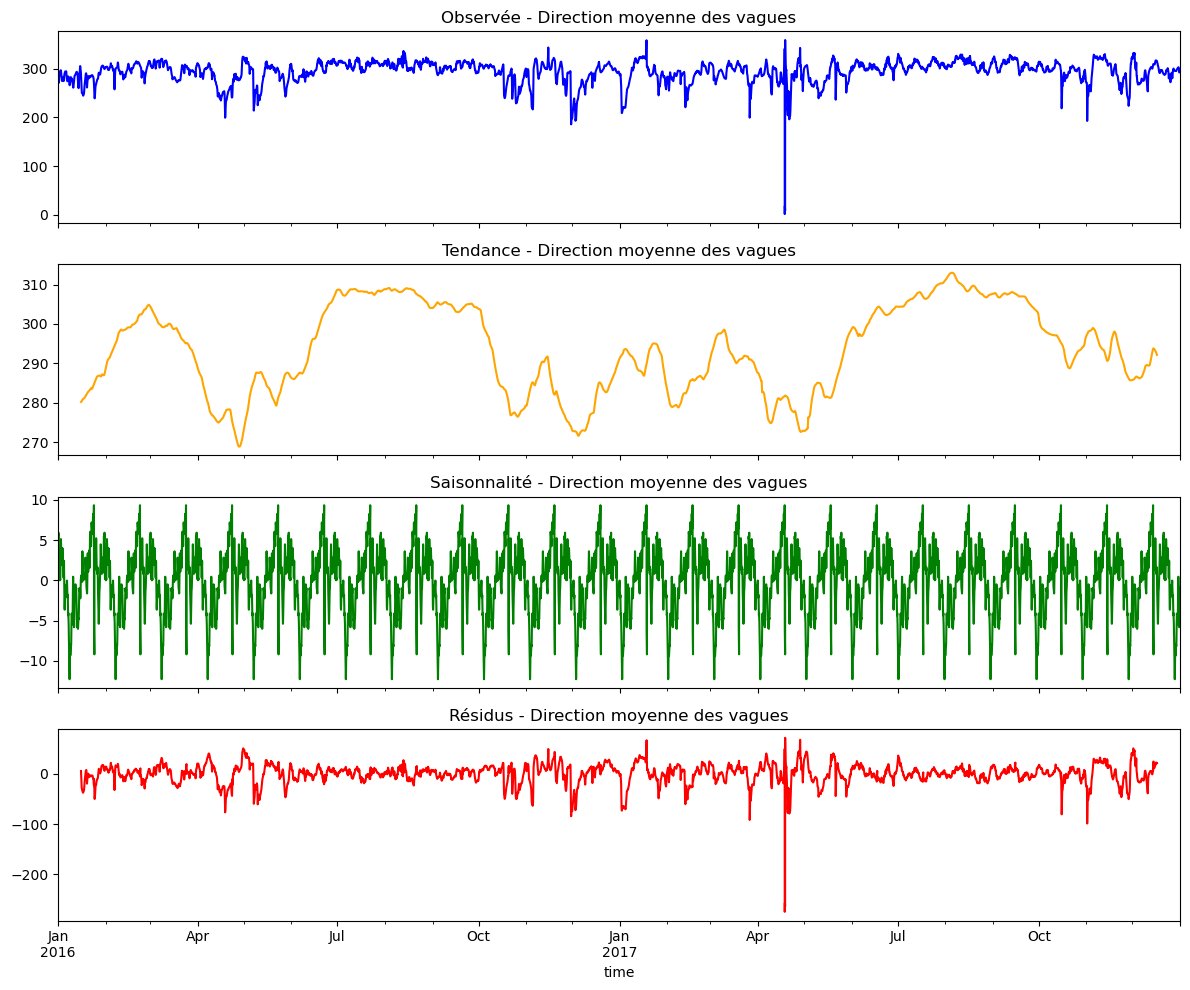

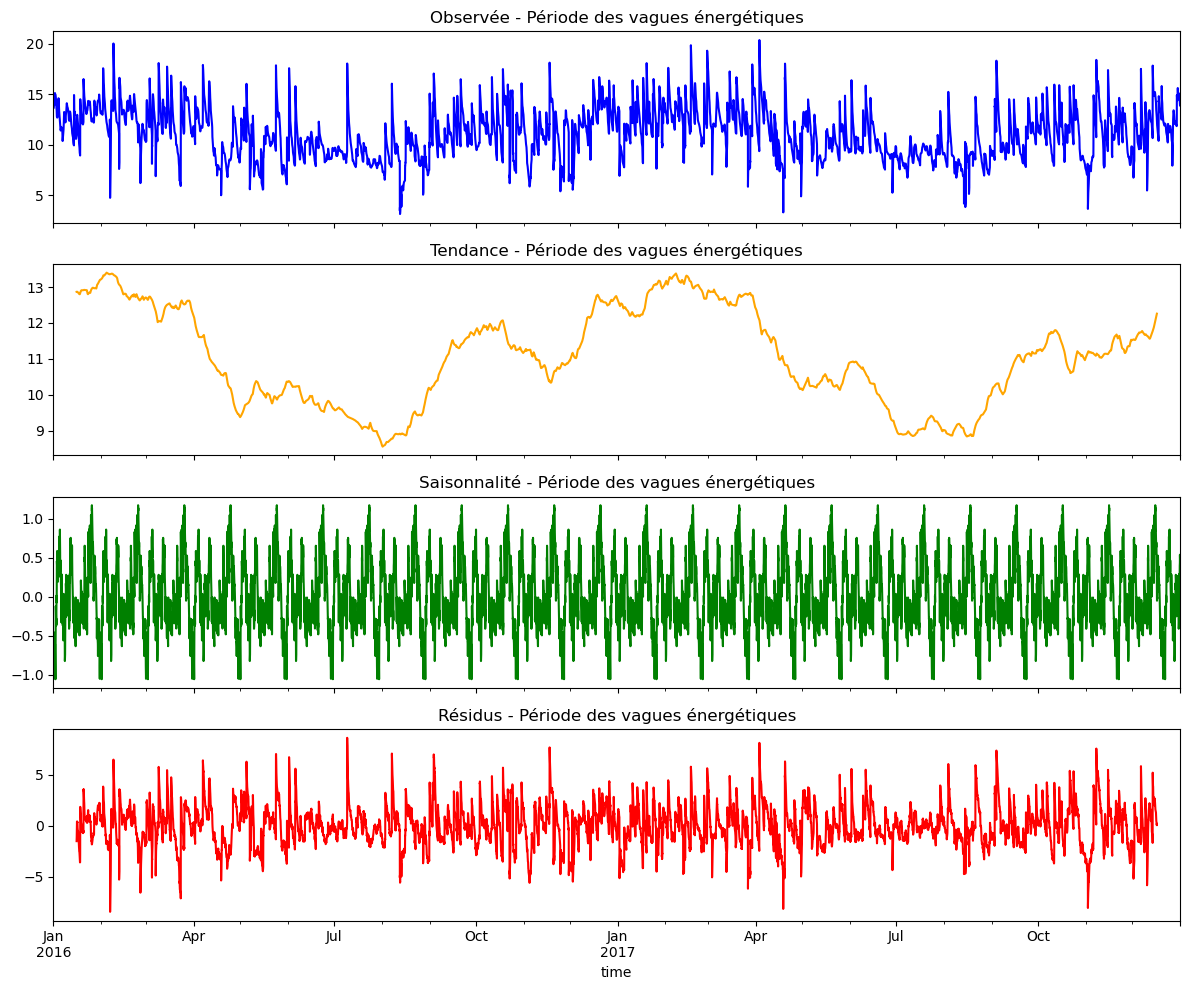

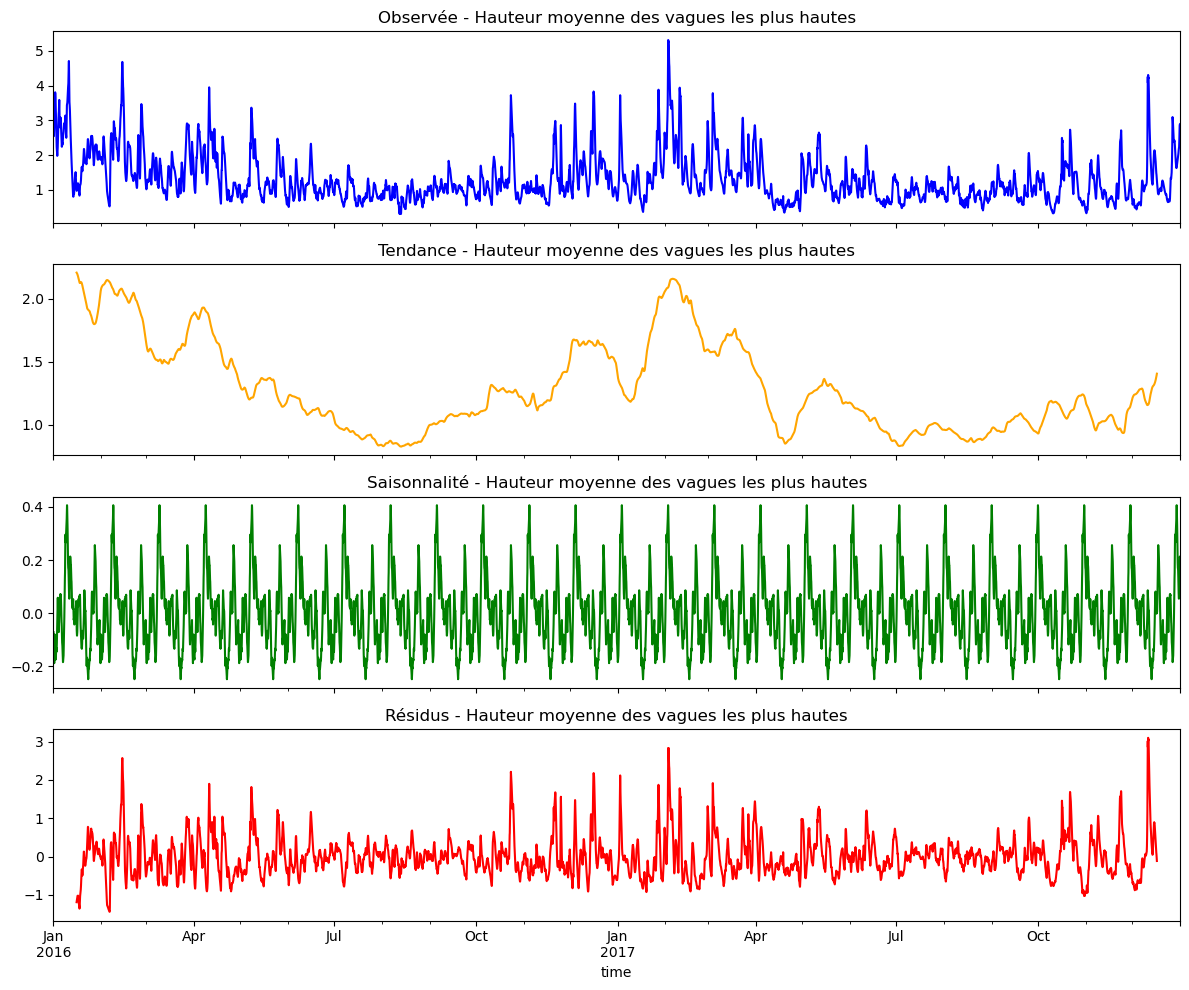

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose


tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

# Décomposition de la série temporelle et agrégation par mois
for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name}.")
        continue
    
    # Décomposition de la série temporelle
    decomposition = seasonal_decompose(df["value"], model="additif", period=24*30)  # Approximation d'une périodicité mensuelle
    
    # Tracer les composants de la décomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title=f"Observée - {name}", color="blue")
    decomposition.trend.plot(ax=axes[1], title=f"Tendance - {name}", color="orange")
    decomposition.seasonal.plot(ax=axes[2], title=f"Saisonnalité - {name}", color="green")
    decomposition.resid.plot(ax=axes[3], title=f"Résidus - {name}", color="red")
    plt.tight_layout()
    plt.show()
    

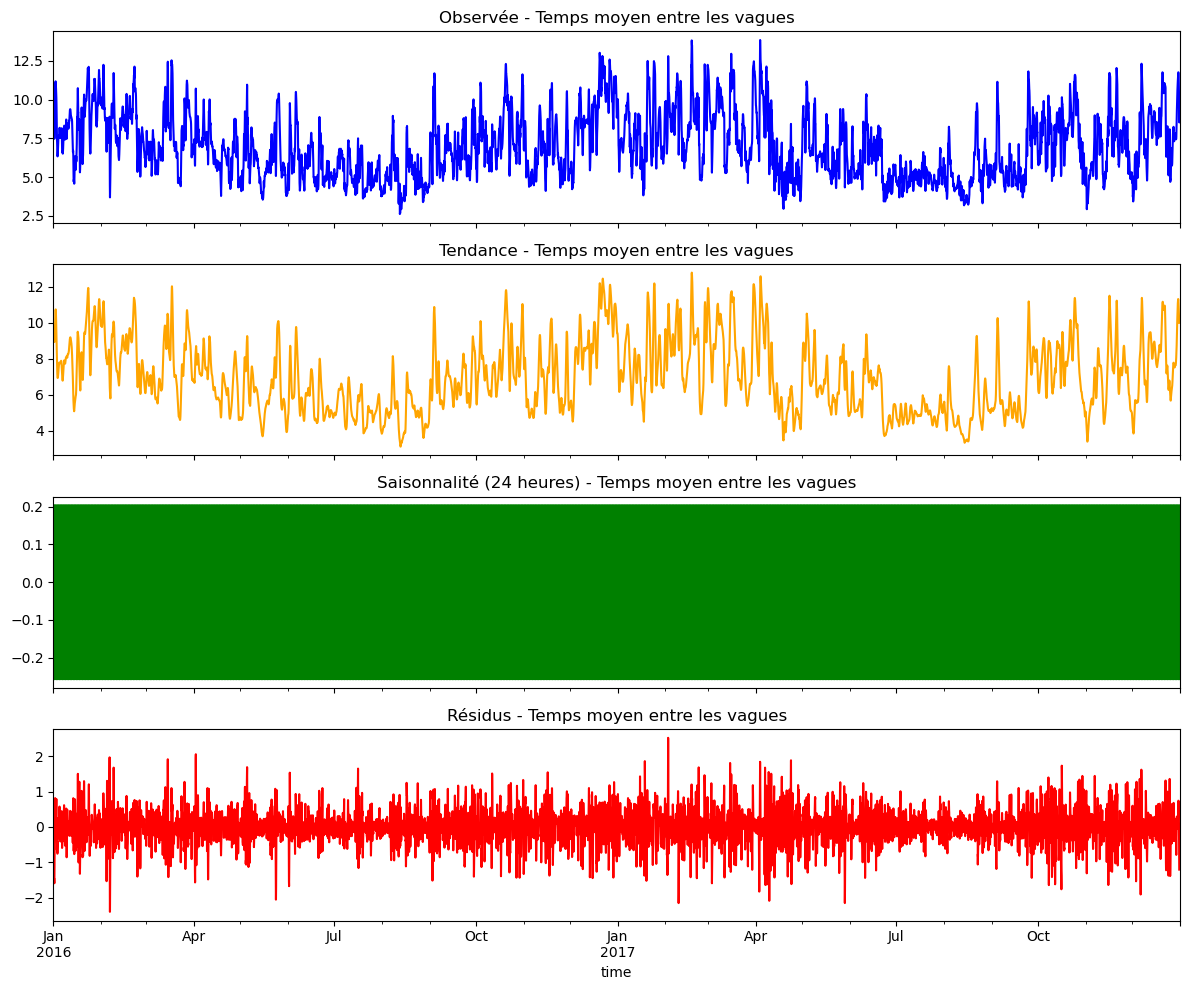

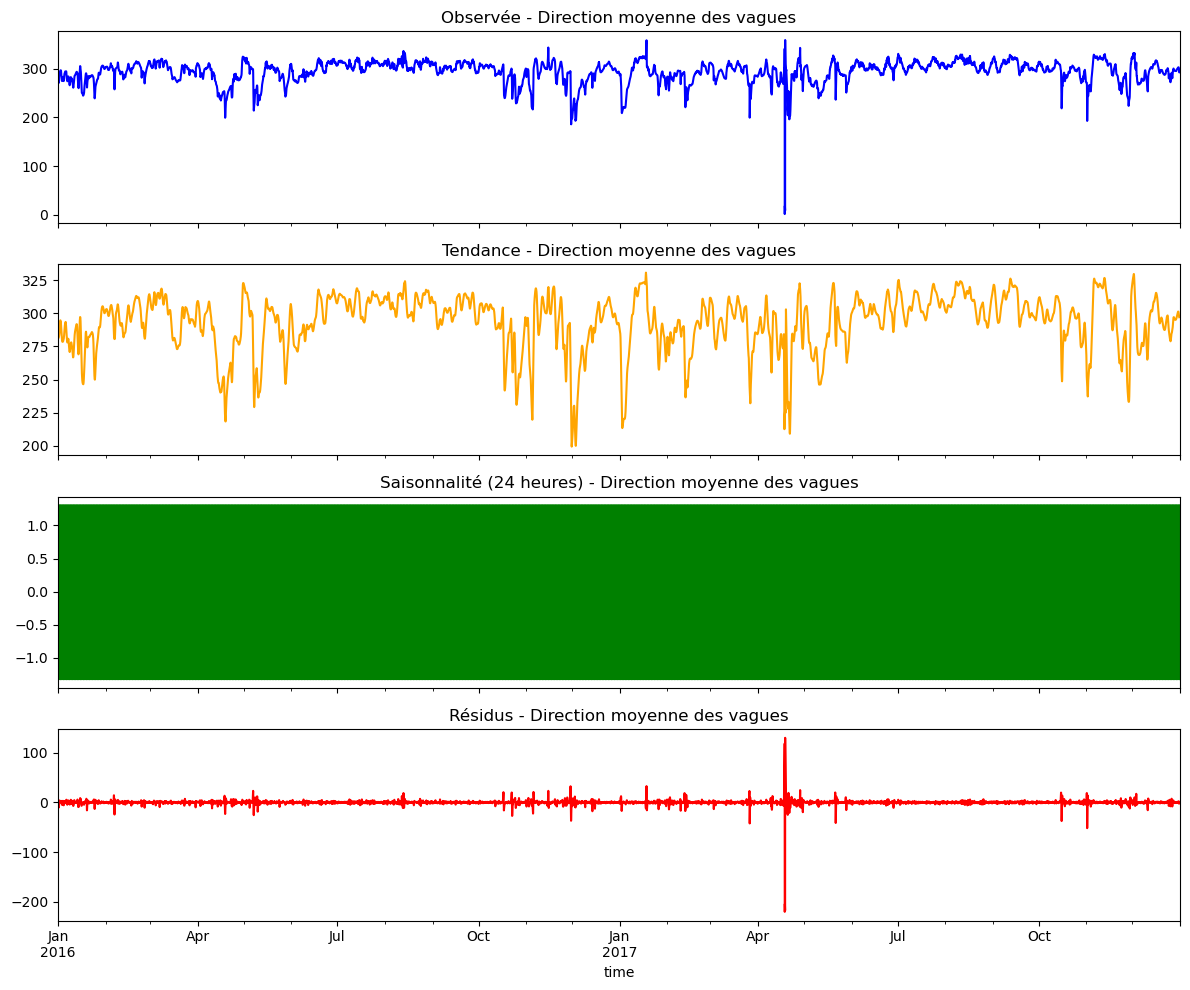

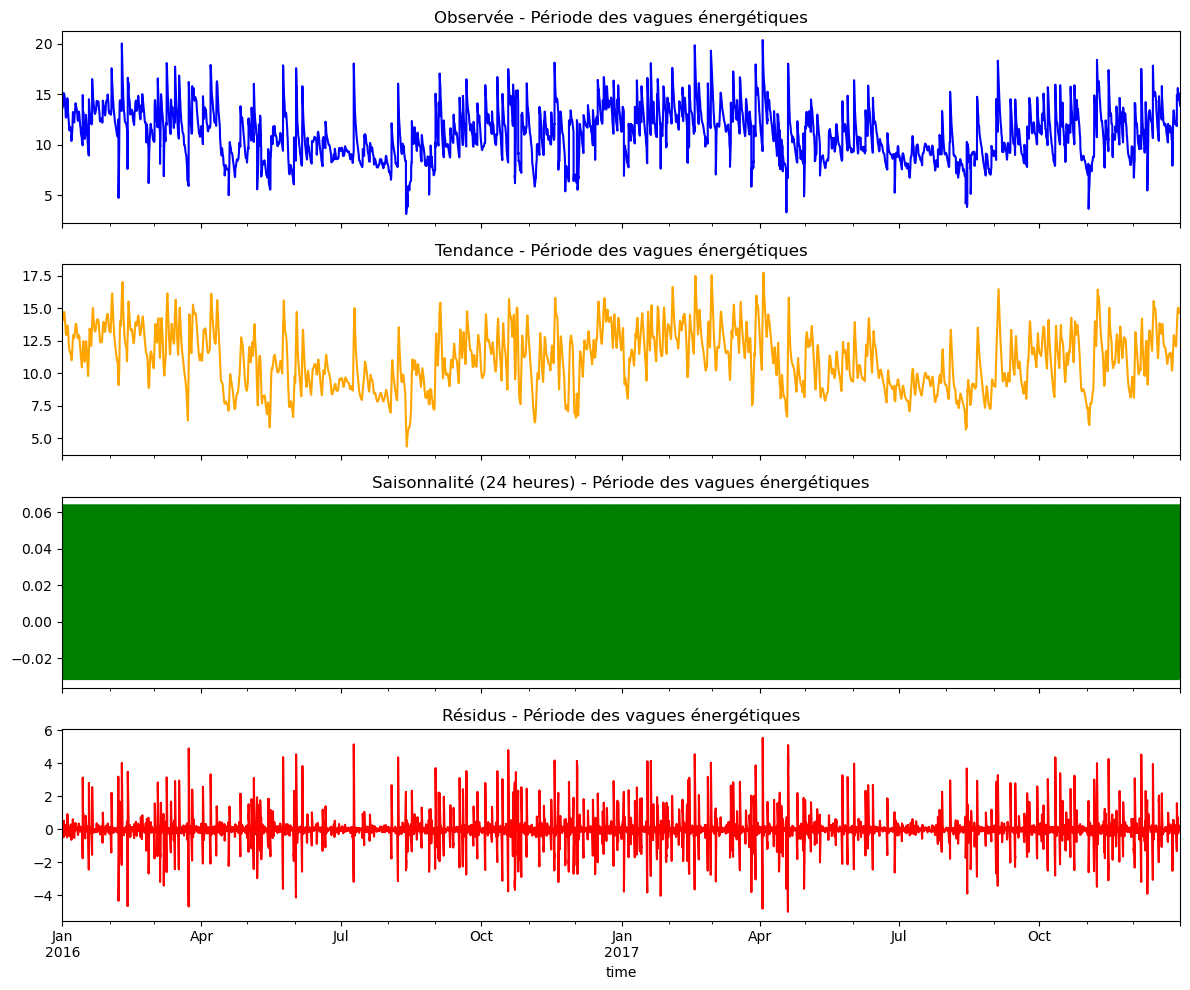

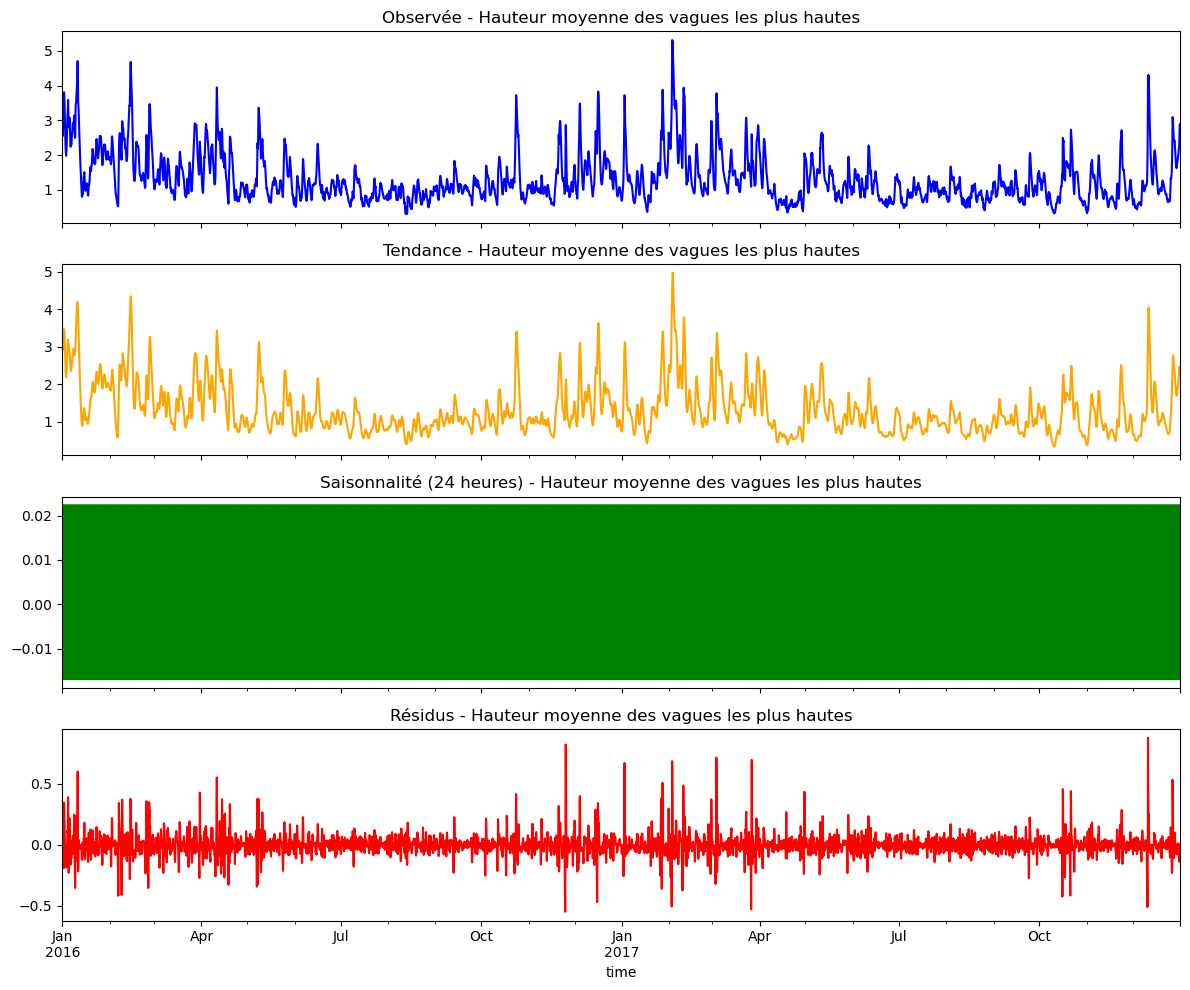

In [60]:
# Décomposition de la série temporelle avec une période de 24 heures
for name, data in tables.items():
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name}.")
        continue
    
    # Décomposition de la série temporelle avec une période de 24 heures
    decomposition = seasonal_decompose(df["value"], model="additive", period=24)  # Périodicité journalière
    
    # Tracer les composants de la décomposition
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    decomposition.observed.plot(ax=axes[0], title=f"Observée - {name}", color="blue")
    decomposition.trend.plot(ax=axes[1], title=f"Tendance - {name}", color="orange")
    decomposition.seasonal.plot(ax=axes[2], title=f"Saisonnalité (24 heures) - {name}", color="green")
    decomposition.resid.plot(ax=axes[3], title=f"Résidus - {name}", color="red")
    plt.tight_layout()
    plt.show()


In [61]:
# # Dunkerke
# lat_target = 56
# lon_target = 4

# filtered_datasets = []
# for file in netcdf_files:
#     # Charger le fichier NetCDF avec xarray
#     ds = xr.open_dataset(file)
    
#     # Utiliser "locs" pour sélectionner les indices de stations les plus proches
#     filtered_data = ds.sel(locs=1000)
#     df = filtered_data.to_dataframe().reset_index()

#     # Ajouter le dataset filtré à la liste
#     filtered_datasets.append(df)



## Anlayse de la stationnarité faible



Par ex : Relation linéaire entre période 3 et 5 ?
Faible stationnarité sur moment 2 implique que l’autovariance dépend que de t-s mais pas de t ni de s. Donc même effet entre 3 et 5 et 4 et 6. Le poids du passé reste égal dans le temps = stationnaire. 

Si le processus admet une espérance constante, une variance et une covariance qui d"pendent du temps. Le processus, n'est pas stationnaire 

DF augmenté : si résidus ne sont pas blanc, DF est faux. 

Test de stationnarité (ADF) :

Nous appliquons le test ADF sur les séries d'origine pour déterminer si elles sont stationnaires (I(0)).
Si la p-valeur du test est inférieure à 0.05, cela signifie que la série est stationnaire (I(0)).
Sinon, nous poursuivons la différenciation.
Différenciation (I(1) et I(2)) :
Si la série n'est pas stationnaire après le test ADF, nous procédons à une différenciation d'ordre 1 (I(1)) et testons à nouveau la stationnarité avec ADF.
Si la série est toujours non stationnaire après I(1), nous effectuons une différenciation d'ordre 2 (I(2)) et refaisons le test.

In [62]:

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

# Fonction pour tester la stationnarité avec ADF
def test_stationarity(series, name="Série"):
    """
    Test de stationnarité sur une série temporelle avec le test ADF.
    """
    print(f"\nTest de stationnarité pour : {name}")
    
    # Suppression des valeurs manquantes en fonction de la dimension 'time'
    series_clean = series.dropna(dim='time')
    
    adf_test = adfuller(series_clean)  # ADF sur les données sans valeurs manquantes
    adf_stat, p_value, lags, obs, crit_values, icbest = adf_test

    print(f"Statistique ADF : {adf_stat:.3f}")
    print(f"P-valeur : {p_value:.3g}")
    print(f"Lags utilisés : {lags}")
    print(f"Valeurs critiques : {crit_values}")

    if p_value < 0.05:
        print(f"La série '{name}' est stationnaire (H0 rejetée).")
        return "I(0)"  # Stationnaire
    else:
        print(f"La série '{name}' n'est PAS stationnaire (H0 non rejetée).")
        return "Non stationnaire"

# Fonction pour effectuer une différenciation (ordre 1 ou 2)
def differentiate(series, order=1):
    """
    Effectuer une différenciation d'ordre spécifié sur une série temporelle.
    """
    return series.diff(dim='time', periods=order).dropna(dim='time')  # Différenciation et suppression des NaN

# Analyser les séries et tester la stationnarité
for name, data in tables.items():
    print(f"\n=== Analyse de stationnarité pour : {name} ===")
    
    # Test de stationnarité pour la série d'origine (I(0))
    result = test_stationarity(data, name=name)
    
    if result == "Non stationnaire":
        # Différencier d'ordre 1 (I(1)) et tester à nouveau
        data_diff_1 = differentiate(data, order=1)
        print(f"\nSérie différenciée d'ordre 1 pour {name}:")
        test_stationarity(data_diff_1, name=f"{name} - Différenciée d'ordre 1")
        
        # Si la série n'est pas stationnaire après différenciation d'ordre 1, différencier d'ordre 2 (I(2))
        data_diff_2 = differentiate(data_diff_1, order=1)
        print(f"\nSérie différenciée d'ordre 2 pour {name}:")
        test_stationarity(data_diff_2, name=f"{name} - Différenciée d'ordre 2")



=== Analyse de stationnarité pour : Temps moyen entre les vagues ===

Test de stationnarité pour : Temps moyen entre les vagues


Statistique ADF : -9.276
P-valeur : 1.29e-15
Lags utilisés : 44
Valeurs critiques : {'1%': -3.430723750472268, '5%': -2.8617051832726124, '10%': -2.5668579227683557}
La série 'Temps moyen entre les vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Direction moyenne des vagues ===

Test de stationnarité pour : Direction moyenne des vagues
Statistique ADF : -9.117
P-valeur : 3.28e-15
Lags utilisés : 44
Valeurs critiques : {'1%': -3.430723750472268, '5%': -2.8617051832726124, '10%': -2.5668579227683557}
La série 'Direction moyenne des vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Période des vagues énergétiques ===

Test de stationnarité pour : Période des vagues énergétiques
Statistique ADF : -15.341
P-valeur : 3.83e-28
Lags utilisés : 3
Valeurs critiques : {'1%': -3.4307228766973052, '5%': -2.8617047971220786, '10%': -2.566857717226239}
La série 'Période des vagues énergétiques' est stationnaire (H0 rejetée).

=== Analyse de statio

## autocorrélation et autocorrélation partielle

Analyse de la série : Temps moyen entre les vagues


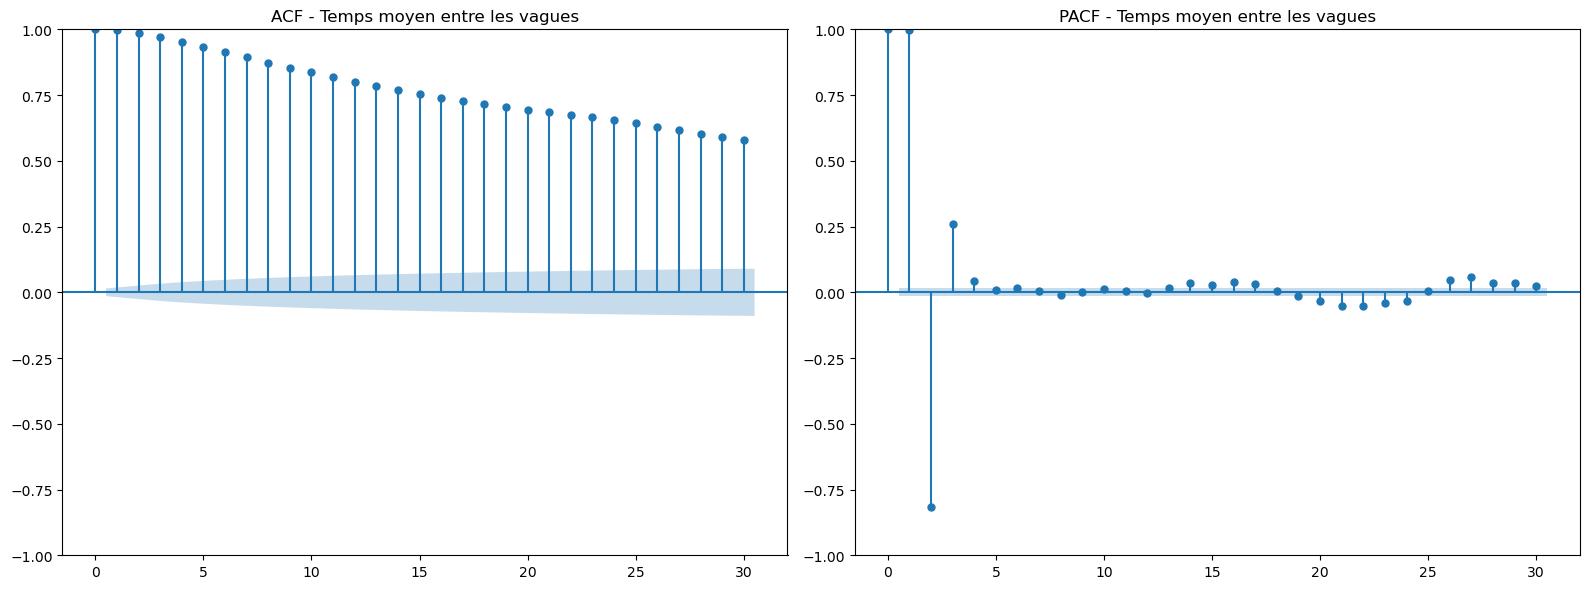

Analyse de la série : Direction moyenne des vagues


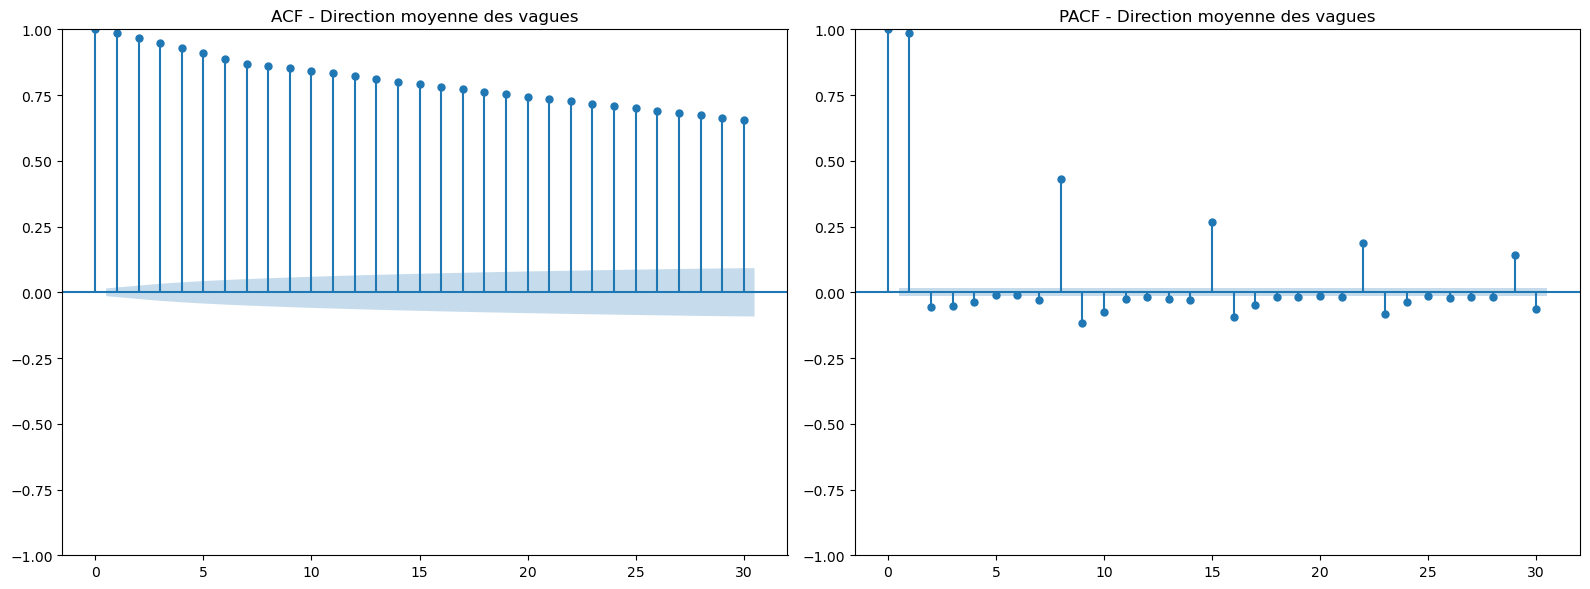

Analyse de la série : Période des vagues énergétiques


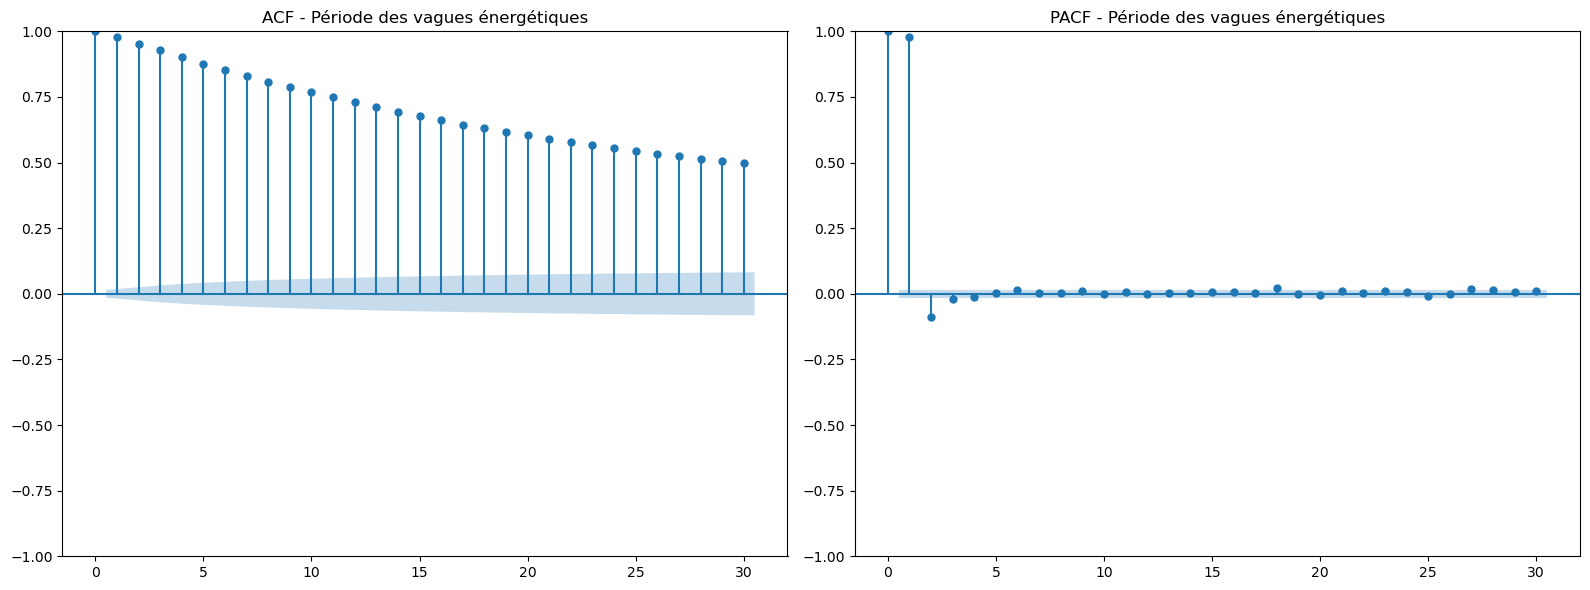

Analyse de la série : Hauteur moyenne des vagues les plus hautes


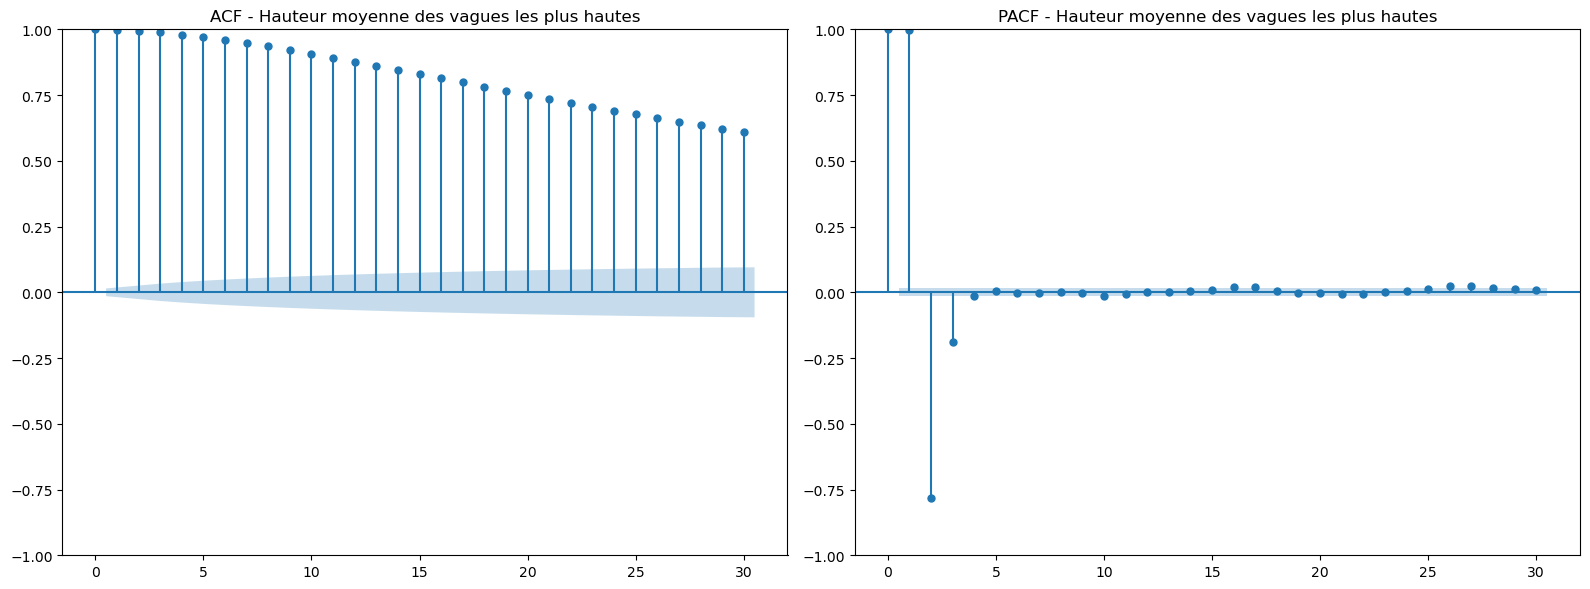

In [63]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}
for name, data in tables.items():
    print(f"Analyse de la série : {name}")
    series = data.values
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(series, lags=30, ax=axes[0])
    axes[0].set_title(f'ACF - {name}')
    plot_pacf(series, lags=30, ax=axes[1])
    axes[1].set_title(f'PACF - {name}')
    plt.tight_layout()
    plt.show()


L'ACF montre une décroissance progressive des corrélations avec l'augmentation du lag.
La PACF montrera une coupure nette après le deux, troisième ou cinquième lag selon la série, indiquant que seul ces premiers décalages ont ne corrélation significative une fois les autres lags pris en compte.
En résumé les séries sont très périodiques

## rapport des données préprocessés

In [64]:
informations_vagues_2016_2017_nazare = pd.read_csv("data/donnees_preprocesse_pour_modelisation", sep=",")

In [65]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(informations_vagues_2016_2017_nazare, title="données préprocessées vagues sur le côte à saint nazaré ", 
#                        explorative=True,  # Active les fonctionnalités avancées
#                        )
# Sauvegarder le rapport en HTML
#profile.to_file("profiling_report_donnees_preprocesses.html")

# Préprocessing

à faire :

Preprocessing

OK filtre par ondelette Wavelet denoising (décomposition de fourrier)

OK transformation variable dégré en degré par du cos ou sin (passage donnée polaire en donnée cartésienne).direction de 1° est très proche sur une cercle de la direction 359°.

Les méthodes

stationnarité, co intégration avec les autres variables ?
mice pour NA
ts fresh pour créer variable
créer des variables à partir du temps
choisir métrique
bien decouper entrainement et test

## passage données polaire en données cartésienne pour les variables de direction


cos(radians)


In [66]:
import numpy as np

def compute_cosine_direction(tables, key="Direction moyenne des vagues"):
    """
    Calcule le cosinus de la direction moyenne des vagues contenue dans la table.
    """
    # Récupérer la DataArray contenant la direction en degrés
    direction_data = tables[key]
    
    # Convertir les degrés en radians
    direction_radians = np.deg2rad(direction_data)
    
    # Calculer le cosinus des valeurs en radians
    cosine_direction = np.cos(direction_radians)
    
    # Conserver les métadonnées et définir un nouveau nom
    cosine_direction.attrs = direction_data.attrs
    cosine_direction.name = "Cosinus de la direction moyenne des vagues"
    
    # Afficher un aperçu des données
    print(cosine_direction)
    
    return cosine_direction

In [67]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

# Pour calculer le cosinus de la direction :
direction_moyene_des_vagues_2016_2017_nazare_en_cos = compute_cosine_direction(tables)


<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 17544)>
array([0.30126787, 0.30199917, 0.30327854, ..., 0.42400316, 0.42261332,
       0.4232215 ])
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-01 ... 2017-12-31T23:...
    station_x_coordinate  float64 350.7
    station_y_coordinate  float64 38.6
Attributes:
    units:       degrees
    long_name:   Mean wave direction
    short_name:  Mean wave direction


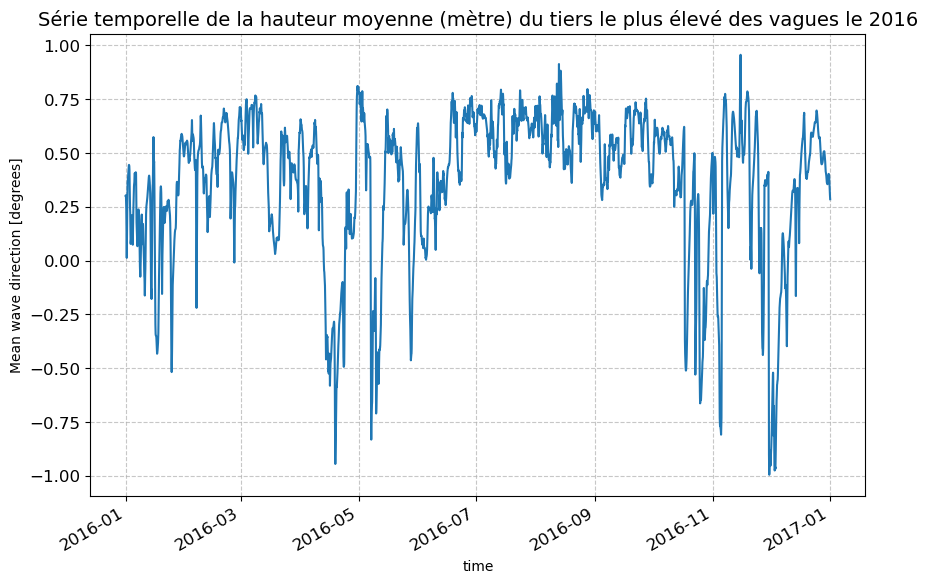

In [68]:
date_filtre = "2016"
table = direction_moyene_des_vagues_2016_2017_nazare_en_cos
data_filtre = table.sel(time=date_filtre)
fig, ax = plt.subplots(figsize=(10, 6))
data_filtre.plot(ax=ax)  # Tracer les données filtrées
ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
plt.show()


## Histogramme et asymétrie

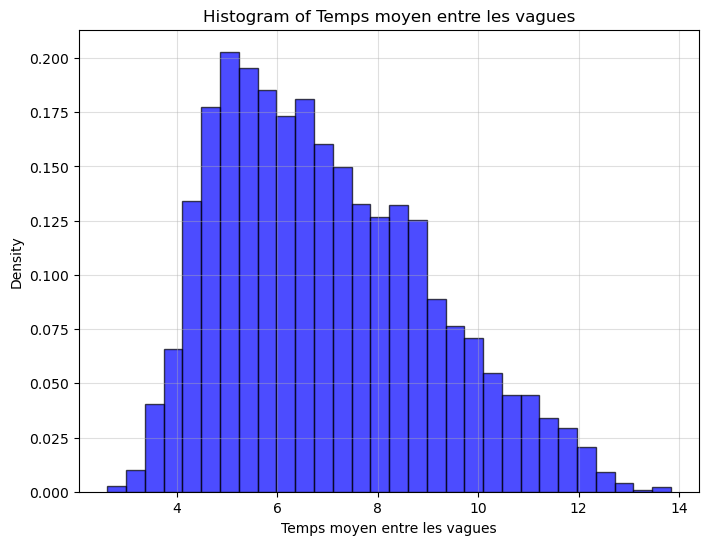

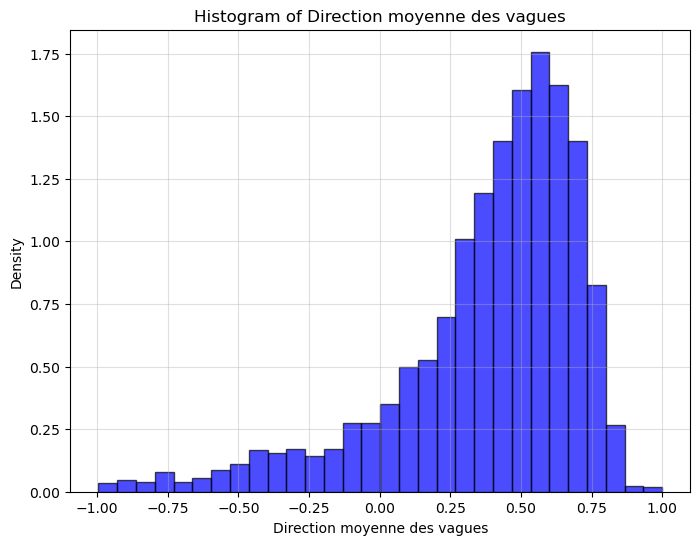

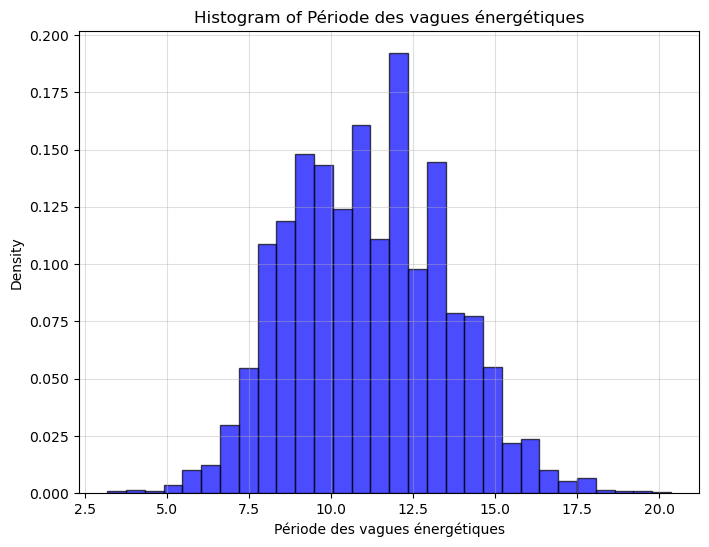

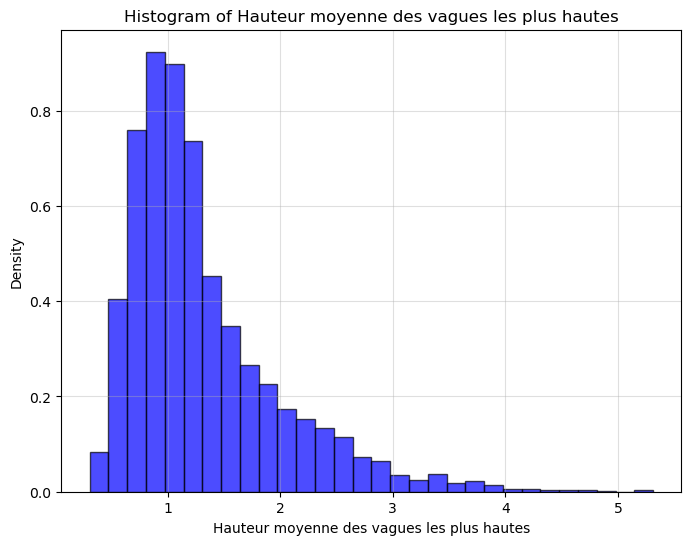

{'Temps moyen entre les vagues': 0.5370932037344989,
 'Direction moyenne des vagues': -1.4318485155986826,
 'Période des vagues énergétiques': 0.18101680628399008,
 'Hauteur moyenne des vagues les plus hautes': 1.6184974027838648}

In [69]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare_en_cos,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}

skewness_results = {}
for name, data in tables.items():
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=30, density=True, alpha=0.7, color="blue", edgecolor="black")
    plt.title(f"Histogram of {name}")
    plt.xlabel(name)
    plt.ylabel("Density")
    plt.grid(alpha=0.4)
    plt.show()
    
    skewness = skew(data)
    skewness_results[name] = skewness

skewness_results


- Direction moyenne des vagues fortement négative
- Hauteur moyenne des vagues les plus hautes : négative
- Asymétrie positive importante.
- La queue droite est beaucoup plus étendue, indiquant des valeurs élevées rares mais significatives (par exemple, des vagues très hautes).

## Corrélation

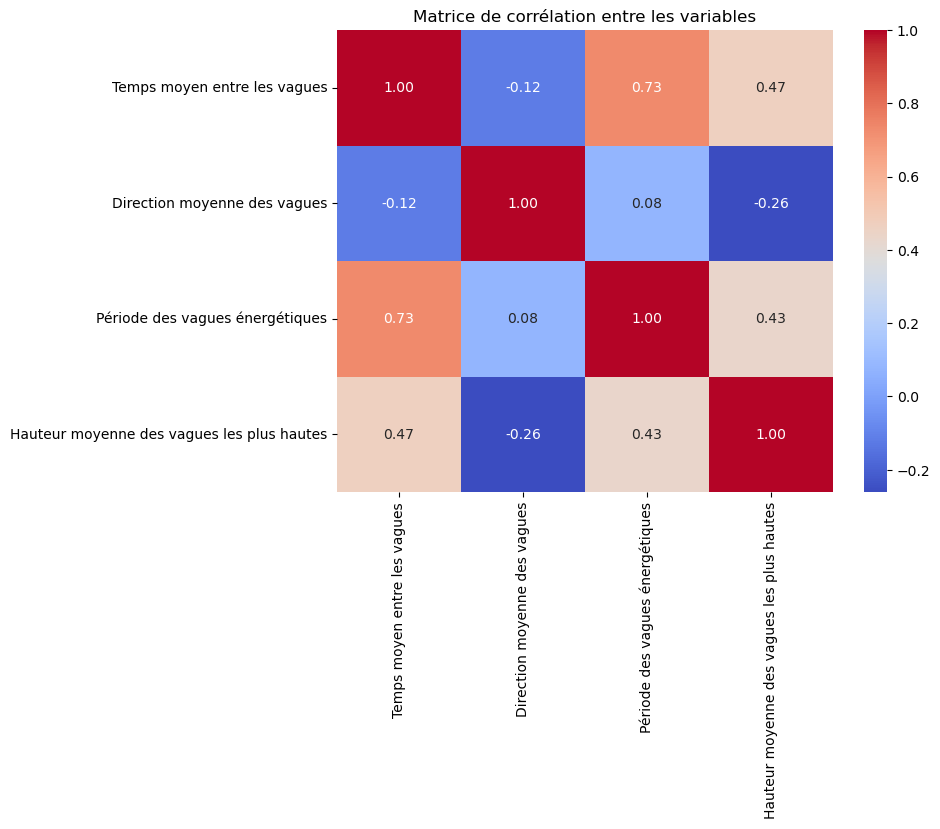

c:\Users\vongu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


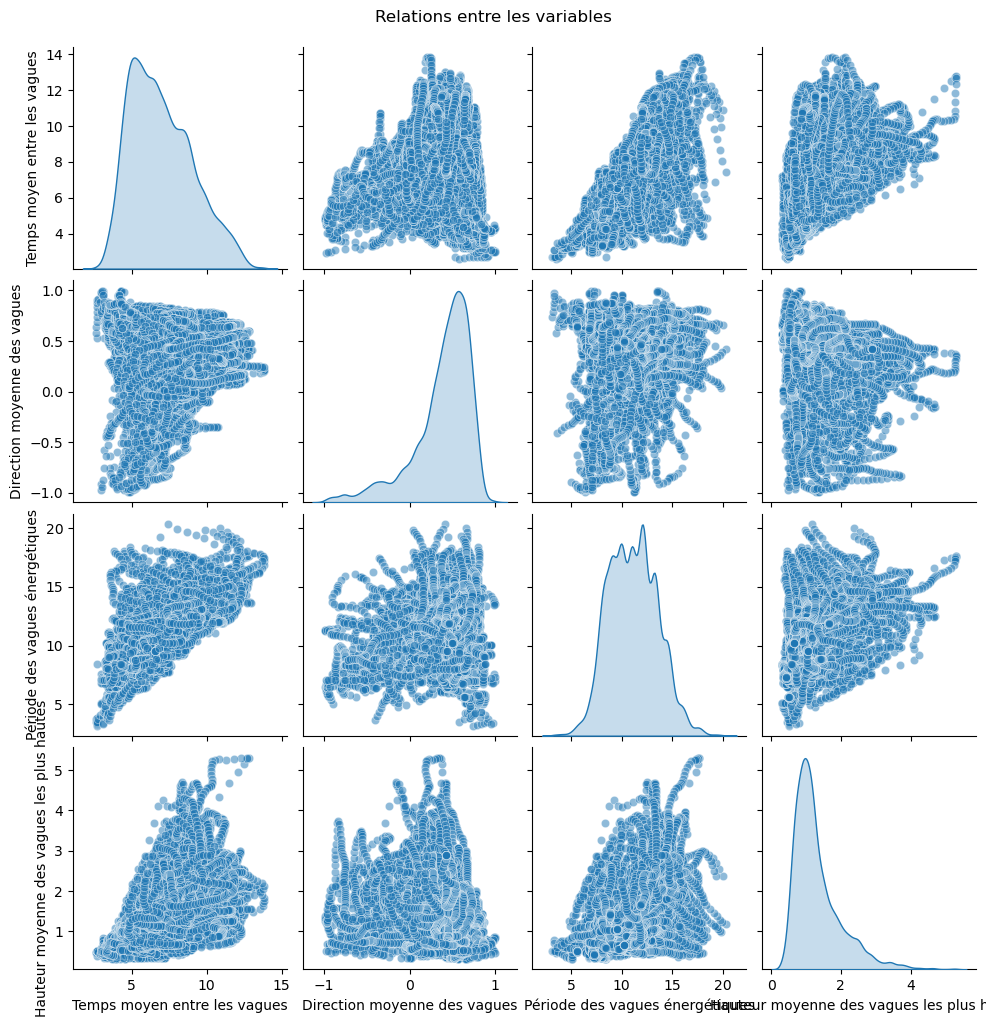

In [70]:
import seaborn as sns

combined_data = pd.DataFrame({
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare.values,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare_en_cos.values,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare.values,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare.values
})

# Calculer la matrice de corrélation
correlation_matrix = combined_data.corr()

# Tracer la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matrice de corrélation entre les variables")
plt.show()

# Tracer les relations entre les variables avec un pair plot
sns.pairplot(combined_data, diag_kind="kde", plot_kws={'alpha': 0.5})
plt.suptitle("Relations entre les variables", y=1.02)
plt.show()


- Temps moyen entre les vagues et Période des vagues énergétiques (0.76) : Forte corrélation positive. Cela signifie que lorsque le temps moyen entre les vagues augmente, la période des vagues énergétiques tend également à augmenter.

- Chaque graphique sur la diagonale montre la distribution individuelle de chaque variable (pt pas necessaire de faire des histogrammes)

- Relations entre paires de variables (hors diagonale) :
    + Temps moyen entre les vagues vs Période des vagues énergétiques : Une forte corrélation positive est visible avec un nuage de points aligné en montée.
    + Direction moyenne des vagues vs Autres variables : Les nuages de points montrent une faible corrélation, indiquant peu ou pas de relation.

## filtre par ondelette


sym5 (Symlets) : Bonne approximation des signaux lisses, adaptée aux phénomènes naturels.
coif1 (Coiflets) : Plus adaptée pour les signaux contenant des variations subtiles, souvent utilisée pour les données environnementales.
Pour des séries longues (1 an avec des pas horaires, soit ~8760 points), un niveau de 4 à 6 est souvent idéal
Pour une sous-série (par exemple, un mois, 720 points), utilisez un niveau de 3
Une année à raison de 8 points par jour (24 heures / 3 heures) correspond à environ 2920 observations.


Traitement de la table : Temps moyen entre les vagues


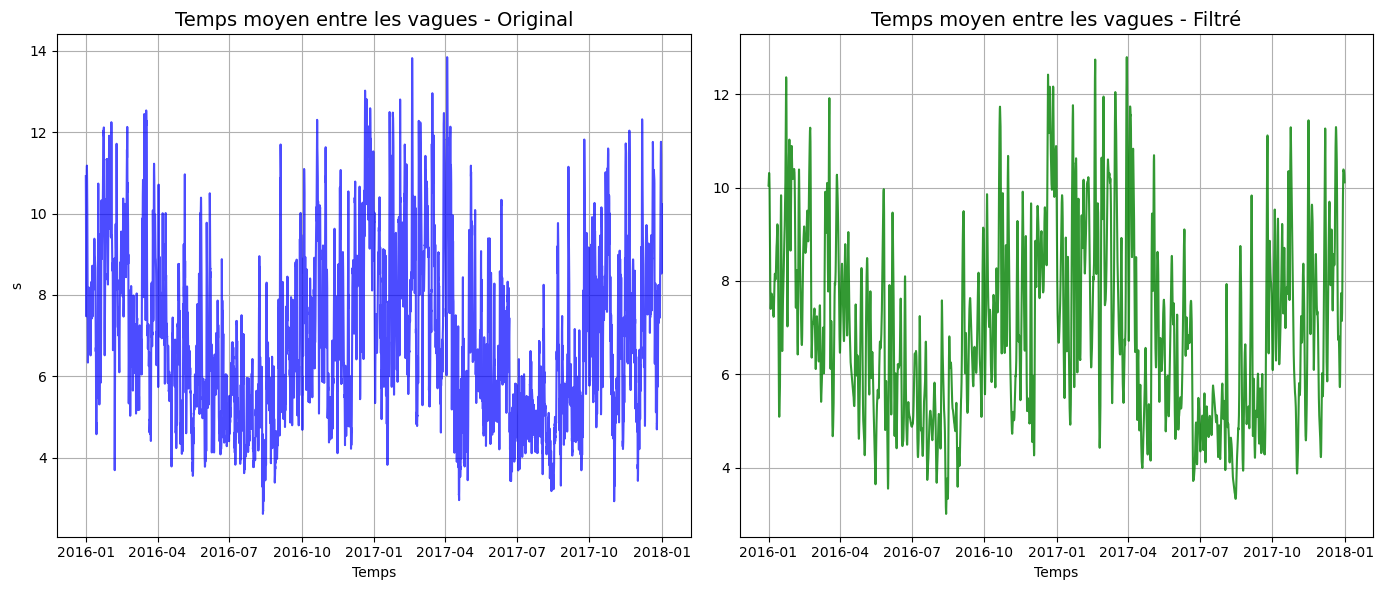

Traitement de la table : Direction moyenne des vagues


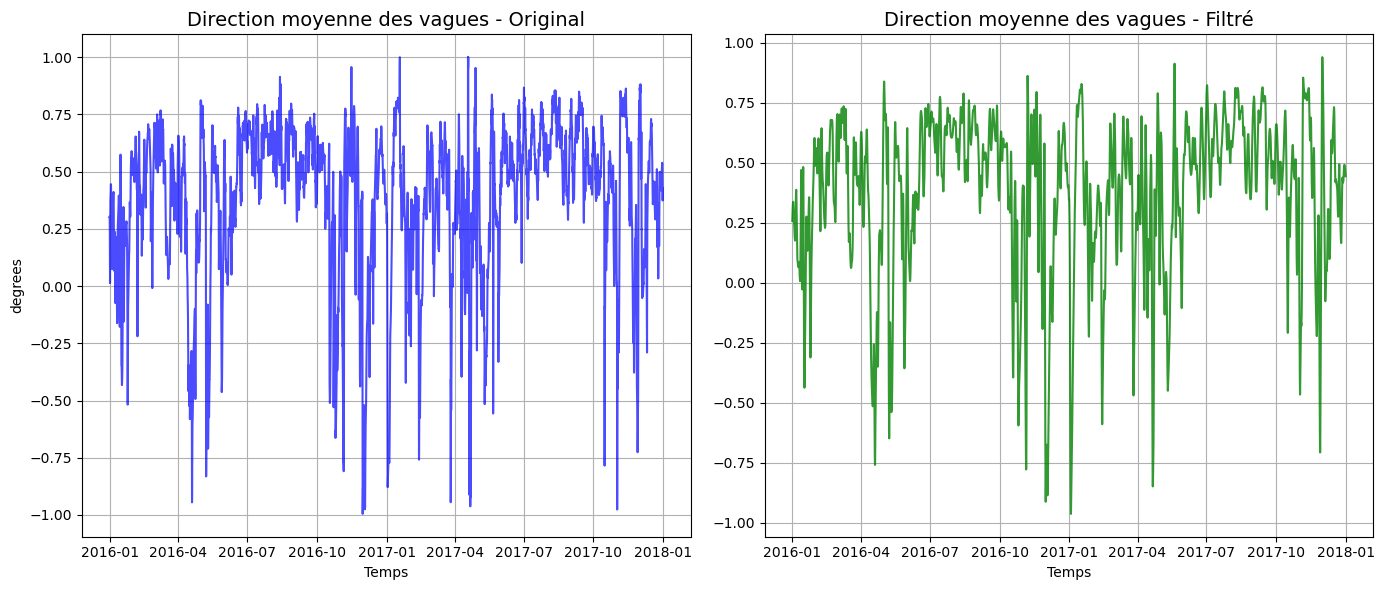

Traitement de la table : Période des vagues énergétiques


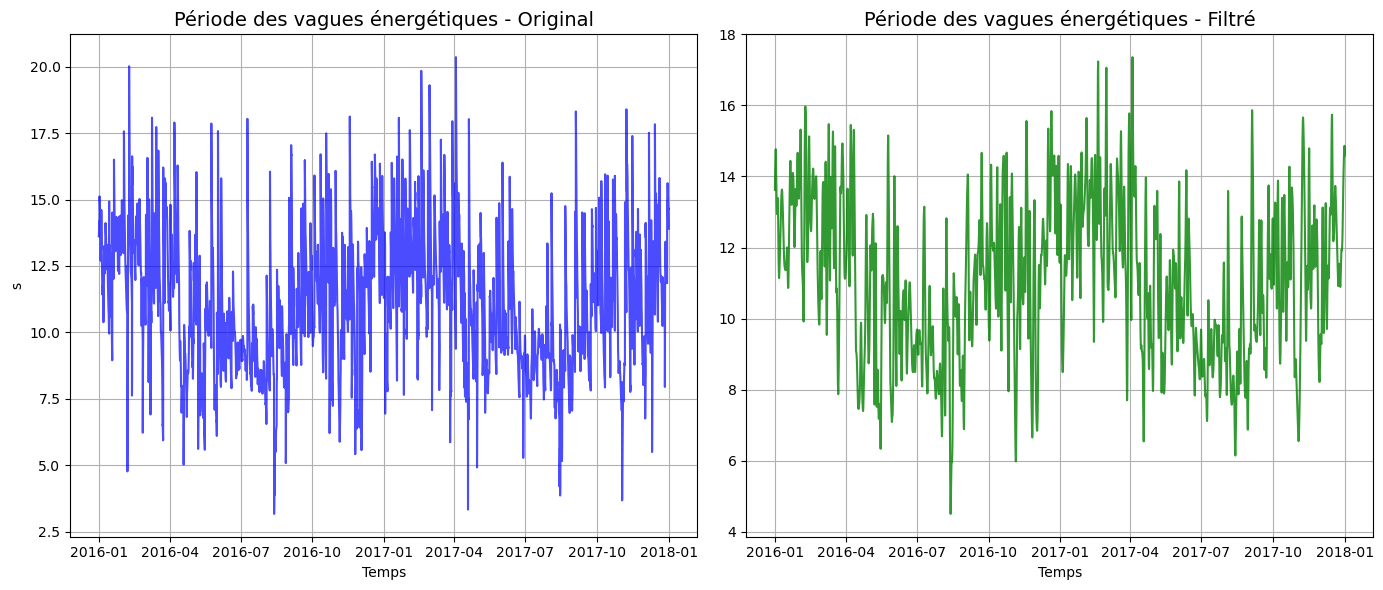

Traitement de la table : Hauteur moyenne des vagues les plus hautes


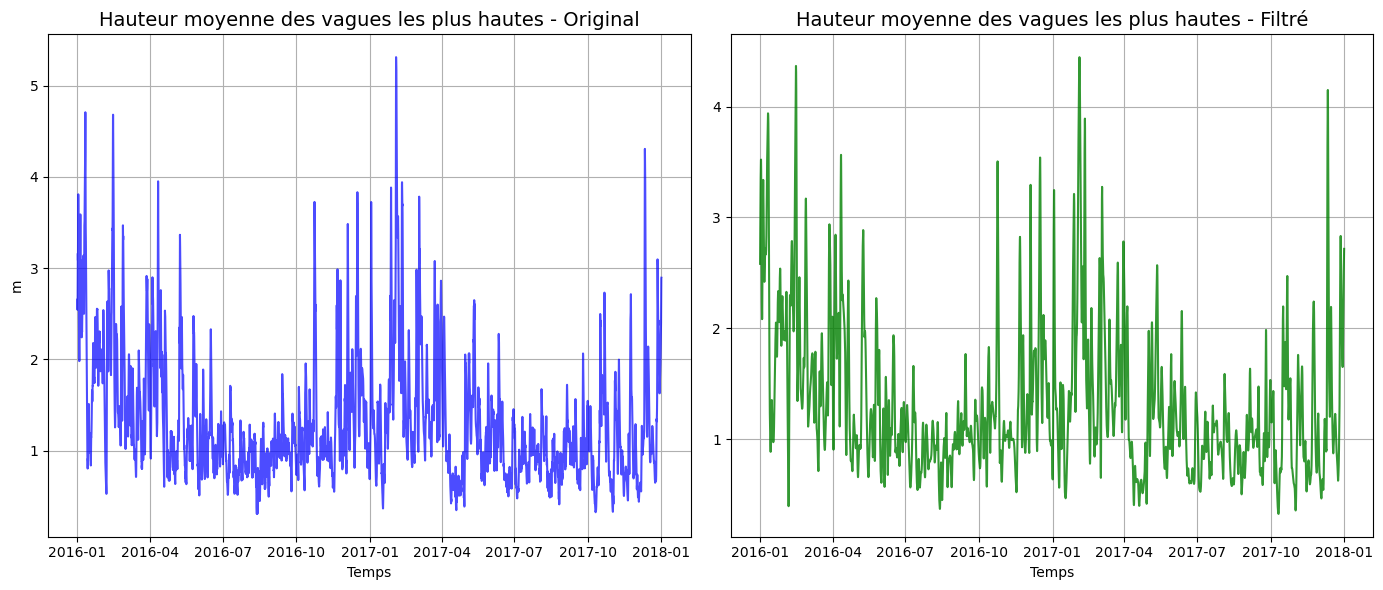

In [71]:
# Paramètres adaptés aux données climatiques
wavelet = 'sym5'  # Ondelette Symlets 5
level = 5  # Niveau de décomposition pour des séries climatiques (ajusté à la longueur des données)

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare_en_cos,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare,
}
for name, data in tables.items():
    print(f"Traitement de la table : {name}")
    
    signal = data.values
    
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    coeffs_filtered = coeffs[:]
    for i in range(1, len(coeffs_filtered)):  
        coeffs_filtered[i] = np.zeros_like(coeffs_filtered[i])
    
    signal_filtered = pywt.waverec(coeffs_filtered, wavelet)
    
    filtered_data = xr.DataArray(
        signal_filtered[:len(signal)],  
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )
    filtered_data.name = f"{name} (Filtré)"
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(data["time"], signal, color="blue", alpha=0.7)
    axes[0].set_title(f"{name} - Original", fontsize=14)
    axes[0].set_xlabel("Temps")
    axes[0].set_ylabel(data.attrs.get('units', 'Valeurs'))
    axes[0].grid(True)
    axes[1].plot(data["time"], signal_filtered[:len(signal)], color="green", alpha=0.8)
    axes[1].set_title(f"{name} - Filtré", fontsize=14)
    axes[1].set_xlabel("Temps")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


In [72]:
temps_moyen_entre_les_vagues_2016_2017_nazare_filtre = temps_moyen_entre_les_vagues_2016_2017_nazare.copy()
direction_moyene_des_vagues_2016_2017_nazare_en_cos_filtre = direction_moyene_des_vagues_2016_2017_nazare_en_cos.copy()
temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare_filtre =temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare.copy()
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare_filtre = hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare.copy()


def filtrage_par_ondelette(data, wavelet, level):
    # Extraction du signal brut
    signal = data.values

    # Décomposition en ondelettes
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    for i in range(1, len(coeffs)):
        coeffs[i] = np.zeros_like(coeffs[i])

    signal_filtered = pywt.waverec(coeffs, wavelet)

    signal_filtered = signal_filtered[:len(signal)]

    return xr.DataArray(
        signal_filtered,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs,
    )

# Application du filtrage à chaque table
temps_moyen_entre_les_vagues_2016_2017_nazare_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_2016_2017_nazare_filtre, wavelet, level
)

direction_moyene_des_vagues_2016_2017_nazare_en_cos_filtre = filtrage_par_ondelette(
    direction_moyene_des_vagues_2016_2017_nazare_en_cos_filtre, wavelet, level
)

temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare_filtre, wavelet, level
)

hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare_filtre = filtrage_par_ondelette(
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare_filtre, wavelet, level
)


## NA

In [73]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare_filtre,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare_en_cos_filtre,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare_filtre,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare_filtre,
}

for name, data in tables.items():
    nan_count = data.isnull().sum().values  
    print(f"{name} : Nombre de NaN : {nan_count}")


Temps moyen entre les vagues : Nombre de NaN : 0
Direction moyenne des vagues : Nombre de NaN : 0
Période des vagues énergétiques : Nombre de NaN : 0
Hauteur moyenne des vagues les plus hautes : Nombre de NaN : 0


## Convertion en format dataframe 

In [74]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_2017_nazare_filtre,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_2017_nazare_en_cos_filtre,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_2017_nazare_filtre,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_nazare_filtre,
}

dataframes = {}

# Processus de conversion
for name, data in tables.items():    
    # Vérifier si le DataArray a un nom, sinon lui en attribuer un
    if data.name is None:
        data.name = name  # Donner un nom basé sur le nom de la table
    
    # Convertir chaque DataArray en DataFrame pandas
    df = data.to_dataframe()  # On convertit la série en pandas DataFrame
    
    # Nous supposons que l'index est déjà 'time' et que ce dernier est bien synchronisé entre les séries.
    df['time'] = df.index  # Ajouter explicitement l'index comme colonne 'time' (si ce n'est pas déjà le cas)
    
    # Ajouter le DataFrame dans le dictionnaire des DataFrames
    dataframes[name] = df

# Fusionner toutes les tables sur 'time'
series_informations_vagues_2016_2017_nazare= pd.concat(dataframes.values(), axis=1)  # Fusionner toutes les tables sur 'time'

# Renommer les colonnes pour éviter les conflits
series_informations_vagues_2016_2017_nazare.columns = [f"{col}" for name, df in dataframes.items() for col in df.columns]

# Supprimer les colonnes doublons (_time, _x_coordinate, _y_coordinate)
columns_to_remove = [col for col in series_informations_vagues_2016_2017_nazare.columns if '_time' in col or '_x_coordinate' in col or '_y_coordinate' in col or 'time' in col]
series_informations_vagues_2016_2017_nazare.drop(columns=columns_to_remove, inplace=True)



In [75]:
series_informations_vagues_2016_2017_nazare.to_csv("data/series_informations_vagues_2016_2017_nazare.csv", index=False)

In [76]:
series_informations_vagues_2016_2017_nazare.head(5)

Temps moyen entre les vagues  \
time                                                
2016-01-01 00:00:00                     10.044133   
2016-01-01 01:00:00                     10.049004   
2016-01-01 02:00:00                     10.060754   
2016-01-01 03:00:00                     10.082587   
2016-01-01 04:00:00                     10.114568   

                     Direction moyenne des vagues  \
time                                                
2016-01-01 00:00:00                      0.257955   
2016-01-01 01:00:00                      0.260235   
2016-01-01 02:00:00                      0.263224   
2016-01-01 03:00:00                      0.267238   
2016-01-01 04:00:00                      0.272282   

                     Période des vagues énergétiques  \
time                                                   
2016-01-01 00:00:00                        13.624450   
2016-01-01 01:00:00                        13.665784   
2016-01-01 02:00:00                        13.714554   
2016-01-01 03:00:00                        13.774067   
2016-01-01 04:00:00                        13.844379   

                     Hauteur moyenne des vagues les plus hautes  
time                                                             
2016-01-01 00:00:00                                    2.581360  
2016-01-01 01:00:00                                    2.614599  
2016-01-01 02:00:00                                    2.654079  
2016-01-01 03:00:00                                    2.702538  
2016-01-01 04:00:00                                    2.760034

In [77]:
assert len(series_informations_vagues_2016_2017_nazare) == 24*365*2+24 #2016 est une année bissextile

In [78]:
series_informations_vagues_2016_2017_nazare.dtypes

Temps moyen entre les vagues                  float64
Direction moyenne des vagues                  float64
Période des vagues énergétiques               float64
Hauteur moyenne des vagues les plus hautes    float64
dtype: object

In [79]:
series_informations_vagues_2016_2017_nazare.columns

Index(['Temps moyen entre les vagues', 'Direction moyenne des vagues',
       'Période des vagues énergétiques',
       'Hauteur moyenne des vagues les plus hautes'],
      dtype='object')

## Valeurs extrêmes

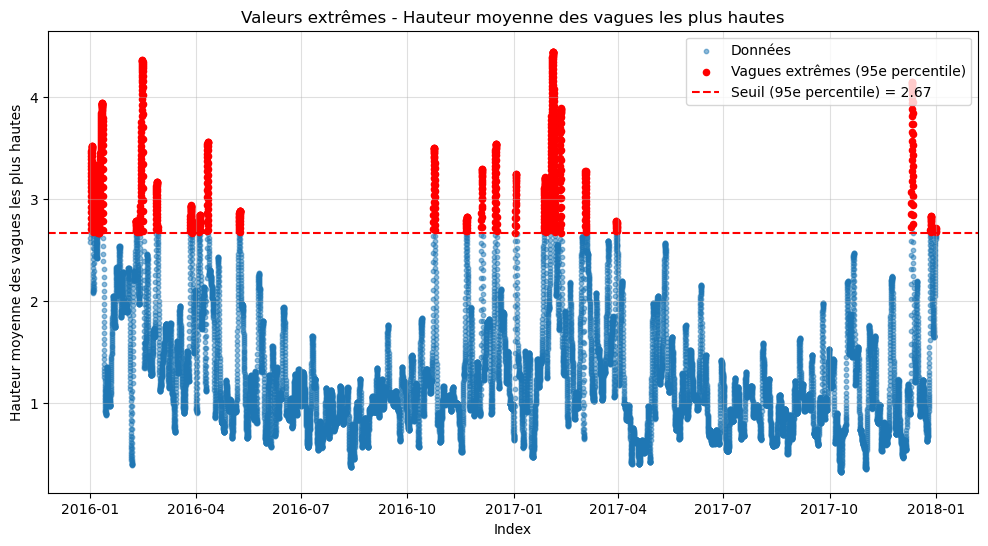

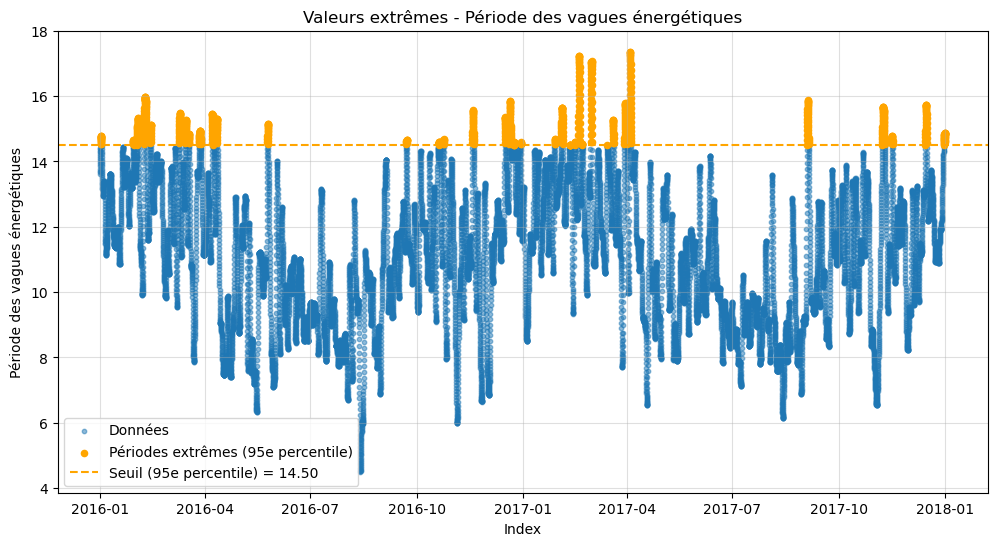

In [80]:
# Seuils pour définir les valeurs extrêmes (95e percentile)
threshold_height = series_informations_vagues_2016_2017_nazare["Hauteur moyenne des vagues les plus hautes"].quantile(0.95)
threshold_period = series_informations_vagues_2016_2017_nazare["Période des vagues énergétiques"].quantile(0.95)

# Identifier les valeurs extrêmes
extreme_wave_heights = series_informations_vagues_2016_2017_nazare[series_informations_vagues_2016_2017_nazare["Hauteur moyenne des vagues les plus hautes"] > threshold_height]
extreme_wave_periods = series_informations_vagues_2016_2017_nazare[series_informations_vagues_2016_2017_nazare["Période des vagues énergétiques"] > threshold_period]

# Visualiser les valeurs extrêmes pour la hauteur des vagues
plt.figure(figsize=(12, 6))
plt.scatter(series_informations_vagues_2016_2017_nazare.index, 
            series_informations_vagues_2016_2017_nazare["Hauteur moyenne des vagues les plus hautes"], 
            alpha=0.5, s=10, label="Données")  # Taille des points réduite
plt.scatter(extreme_wave_heights.index, 
            extreme_wave_heights["Hauteur moyenne des vagues les plus hautes"],
            color="red", s=20, label="Vagues extrêmes (95e percentile)")  # Points extrêmes légèrement plus grands
plt.axhline(y=threshold_height, color="red", linestyle="--", label=f"Seuil (95e percentile) = {threshold_height:.2f}")
plt.title("Valeurs extrêmes - Hauteur moyenne des vagues les plus hautes")
plt.xlabel("Index")
plt.ylabel("Hauteur moyenne des vagues les plus hautes")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Visualiser les valeurs extrêmes pour la période des vagues énergétiques
plt.figure(figsize=(12, 6))
plt.scatter(series_informations_vagues_2016_2017_nazare.index, 
            series_informations_vagues_2016_2017_nazare["Période des vagues énergétiques"], 
            alpha=0.5, s=10, label="Données")  # Taille des points réduite
plt.scatter(extreme_wave_periods.index, 
            extreme_wave_periods["Période des vagues énergétiques"],
            color="orange", s=20, label="Périodes extrêmes (95e percentile)")  # Points extrêmes légèrement plus grands
plt.axhline(y=threshold_period, color="orange", linestyle="--", label=f"Seuil (95e percentile) = {threshold_period:.2f}")
plt.title("Valeurs extrêmes - Période des vagues énergétiques")
plt.xlabel("Index")
plt.ylabel("Période des vagues énergétiques")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


## Ajouter les informations des balises proches

In [83]:
def load_info_balise(numero_balise):
    #data_folder = "data/data_collect" #(Pour Nhi)
    data_folder = "data"
    netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

    temps_moyen_entre_les_vagues_2016 = xr.open_dataset(netcdf_files[0])['mp1'].isel(locs=numero_balise)
    direction_moyene_des_vagues_2016 = xr.open_dataset(netcdf_files[2])['mwd'].isel(locs=numero_balise)
    temps_moyen_entre_les_vagues_energetiques_2016= xr.open_dataset(netcdf_files[4])['pp1d'].isel(locs=numero_balise)
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016  = xr.open_dataset(netcdf_files[6])['swh'].isel(locs=numero_balise)
    tables_2016 = [ 
        temps_moyen_entre_les_vagues_2016 ,
        direction_moyene_des_vagues_2016 ,
        temps_moyen_entre_les_vagues_energetiques_2016,
        hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016
    ]

    temps_moyen_entre_les_vagues_2017  = xr.open_dataset(netcdf_files[1])['mp1'].isel(locs=numero_balise)
    direction_moyene_des_vagues_2017 = xr.open_dataset(netcdf_files[3])['mwd'].isel(locs=numero_balise)
    temps_moyen_entre_les_vagues_energetiques_2017 = xr.open_dataset(netcdf_files[5])['pp1d'].isel(locs=numero_balise)
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017 = xr.open_dataset(netcdf_files[7])['swh'].isel(locs=numero_balise)

    # Listes des séries temporelles originales et complémentaires
    tables_2017 =[
        temps_moyen_entre_les_vagues_2017 ,
        direction_moyene_des_vagues_2017 ,
        temps_moyen_entre_les_vagues_energetiques_2017,
        hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2017
    ]

    titles = [
        "Série temporelle du temps moyen entre les vagues",
        "Série temporelle de la direction moyenne des vagues",
        "Série temporelle de la période des vagues océaniques les plus énergétiques",
        "Série temporelle de la hauteur moyenne (mètre) du tiers le plus élevé des vagues"
    ]

    merged_table_names = [
        "temps_moyen_entre_les_vagues_2016_2017",
        "direction_moyene_des_vagues_2016_2017",
        "temps_moyen_entre_les_vagues_energetiques_2016_2017",
        "hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017"
    ]

    # Concaténer les DataArrays pour chaque variable
    temps_moyen_entre_les_vagues_2016_2017 = xr.concat([tables_2016[0], tables_2017[0]], dim="time")
    direction_moyene_des_vagues_2016_2017 = xr.concat([tables_2016[1], tables_2017[1]], dim="time")
    temps_moyen_entre_les_vagues_energetiques_2016_2017 = xr.concat([tables_2016[2], tables_2017[2]], dim="time")
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017 = xr.concat([tables_2016[3], tables_2017[3]], dim="time")

    # Initialiser le dictionnaire final et la liste des tables fusionnées

    merged_tables_list = [temps_moyen_entre_les_vagues_2016_2017,
    direction_moyene_des_vagues_2016_2017,
    temps_moyen_entre_les_vagues_energetiques_2016_2017 ,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017]

    tables = {
        f"temps_moyen_entre_les_vagues_2016_2017_{numero_balise}": temps_moyen_entre_les_vagues_2016_2017,
        f"direction_moyene_des_vagues_2016_2017_{numero_balise}": direction_moyene_des_vagues_2016_2017,
        f"temps_moyen_entre_les_vagues_energetiques_2016_2017_{numero_balise}": temps_moyen_entre_les_vagues_energetiques_2016_2017,
        f"hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_{numero_balise}": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017,
    }

    return tables

def extract_tables_for_station(numero_balise):
    """
    Extrait un dictionnaire contenant les tables de données pour la balise spécifiée.
    """
    # Charger et renommer les données pour la balise donnée (fonction préalablement définie)
    data = load_info_balise(numero_balise)
    
    # Construire le dictionnaire en mappant les clés explicites aux DataArrays renommées
    tables = {
        "Temps moyen entre les vagues": data[f"temps_moyen_entre_les_vagues_2016_2017_{numero_balise}"],
        "Direction moyenne des vagues": data[f"direction_moyene_des_vagues_2016_2017_{numero_balise}"],
        "Période des vagues énergétiques": data[f"temps_moyen_entre_les_vagues_energetiques_2016_2017_{numero_balise}"],
        "Hauteur moyenne des vagues les plus hautes": data[f"hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_{numero_balise}"],
    }
    return tables



In [84]:
tables_1129 = extract_tables_for_station(1129)
tables_1129["Direction moyenne des vagues"] = compute_cosine_direction(tables_1129)

tables_1118 = extract_tables_for_station(1118)
tables_1118["Direction moyenne des vagues"] = compute_cosine_direction(tables_1118)

tables_1119 = extract_tables_for_station(1119)
tables_1119["Direction moyenne des vagues"] = compute_cosine_direction(tables_1119)


<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 17544)>
array([0.36730487, 0.36801818, 0.36926595, ..., 0.48135147, 0.47992214,
       0.48051084])
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-01 ... 2017-12-31T23:...
    station_x_coordinate  float64 350.7
    station_y_coordinate  float64 38.5
Attributes:
    units:       degrees
    long_name:   Mean wave direction
    short_name:  Mean wave direction
<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 17544)>
array([0.36757239, 0.36685894, 0.36739405, ..., 0.47908076, 0.47857572,
       0.48042675])
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-01 ... 2017-12-31T23:...
    station_x_coordinate  float64 350.6
    station_y_coordinate  float64 38.6
Attributes:
    units:       degrees
    long_name:   Mean wave direction
    short_name:  Mean wave direction
<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 17544)>
array([0.40436

In [85]:
def appliquer_filtrage_sur_tables(tables, wavelet, level):
    """
    Applique la fonction de filtrage par ondelette à chaque DataArray du dictionnaire 'tables'.
    
    Paramètres :
        tables (dict) : Dictionnaire où chaque clé correspond à une variable (ex. "Temps moyen entre les vagues")
                         et chaque valeur est une xarray.DataArray.
        wavelet : L'ondelette à utiliser pour le filtrage.
        level (int) : Le niveau de filtrage à appliquer.
    
    Retourne :
        dict : Un nouveau dictionnaire contenant les DataArrays filtrées.
    """
    tables_filtrees = {}
    for key, data_array in tables.items():
        tables_filtrees[key] = filtrage_par_ondelette(data_array, wavelet, level)
    return tables_filtrees

In [86]:
# Application du filtrage par ondelette à chaque table pour la balise 1129
tables_1129_filtrees = appliquer_filtrage_sur_tables(tables_1129, wavelet, level)
tables_1118_filtrees = appliquer_filtrage_sur_tables(tables_1118, wavelet, level)
tables_1119_filtrees = appliquer_filtrage_sur_tables(tables_1119, wavelet, level)

In [87]:
def mettre_à_jour_dict(data, numero_balise):
    """
    Mettre à jour de dictionnaire contenant les tables de données pour la balise spécifiée.
    """
    tables = {
        f"temps_moyen_entre_les_vagues_2016_2017_{numero_balise}": data[ "Temps moyen entre les vagues"],
        f"direction_moyene_des_vagues_2016_2017_{numero_balise}": data["Direction moyenne des vagues"],
        f"temps_moyen_entre_les_vagues_energetiques_2016_2017_{numero_balise}": data["Période des vagues énergétiques"],
        f"hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_{numero_balise}": data["Hauteur moyenne des vagues les plus hautes"],
    }

    return tables

In [88]:
tables_1129_filtrees = mettre_à_jour_dict(tables_1129_filtrees, 1129)
tables_1118_filtrees = mettre_à_jour_dict(tables_1118_filtrees, 1118)
tables_1119_filtrees = mettre_à_jour_dict(tables_1119_filtrees, 1119)

In [89]:
import pandas as pd

def convertir_tables_en_dataframe(tables):
    """
    Convertit un dictionnaire de tables xarray en un dictionnaire de DataFrames pandas.
    """
    dataframes = {}

    # Processus de conversion
    for name, data in tables.items():
        # Vérifier si le DataArray a un nom, sinon lui en attribuer un
        if data.name is None:
            data = data.rename(name)  # Utiliser .rename() pour éviter l'erreur

        # Convertir chaque DataArray en DataFrame pandas
        df = data.to_dataframe()  # On convertit la série en pandas DataFrame
        
        # Ajouter explicitement l'index 'time' comme colonne (si ce n'est pas déjà fait)
        if 'time' not in df.columns:
            df['time'] = df.index
        
        # Ajouter le DataFrame dans le dictionnaire des DataFrames
        dataframes[name] = df

    # Fusionner toutes les tables sur 'time'
    df_merged = pd.concat(dataframes.values(), axis=1)  

    # Supprimer les colonnes doublons (_time, _x_coordinate, _y_coordinate, et les répétitions de 'time')
    columns_to_remove = [col for col in df_merged.columns if '_time' in col or '_x_coordinate' in col or '_y_coordinate' in col or col == 'time']
    df_merged.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    return df_merged


In [90]:
series_informations_vagues_2016_2017_1129 = convertir_tables_en_dataframe(tables_1129_filtrees)
series_informations_vagues_2016_2017_1118 = convertir_tables_en_dataframe(tables_1118_filtrees)
series_informations_vagues_2016_2017_1119 = convertir_tables_en_dataframe(tables_1119_filtrees)

In [91]:
series_informations_vagues_2016_2017_1129.to_csv("data/donnees_preprocessees_balise_1129.csv", index=False)
series_informations_vagues_2016_2017_1118.to_csv("data/donnees_preprocessees_balise_1118.csv", index=False)
series_informations_vagues_2016_2017_1119.to_csv("data/donnees_preprocessees_balise_1119.csv", index=False)

In [92]:
#Fusion toutes les données
dfs = [
    series_informations_vagues_2016_2017_nazare,
    series_informations_vagues_2016_2017_1129,
    series_informations_vagues_2016_2017_1118,
    series_informations_vagues_2016_2017_1119
]

series_informations_vagues_2016_2017_final = dfs[0]
for df in dfs[1:]:
    series_informations_vagues_2016_2017_final = pd.merge(series_informations_vagues_2016_2017_final, df, on="time", how="left")


In [93]:
series_informations_vagues_2016_2017_final.columns

Index(['Temps moyen entre les vagues', 'Direction moyenne des vagues',
       'Période des vagues énergétiques',
       'Hauteur moyenne des vagues les plus hautes',
       'temps_moyen_entre_les_vagues_2016_2017_1129',
       'direction_moyene_des_vagues_2016_2017_1129',
       'temps_moyen_entre_les_vagues_energetiques_2016_2017_1129',
       'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129',
       'temps_moyen_entre_les_vagues_2016_2017_1118',
       'direction_moyene_des_vagues_2016_2017_1118',
       'temps_moyen_entre_les_vagues_energetiques_2016_2017_1118',
       'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1118',
       'temps_moyen_entre_les_vagues_2016_2017_1119',
       'direction_moyene_des_vagues_2016_2017_1119',
       'temps_moyen_entre_les_vagues_energetiques_2016_2017_1119',
       'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1119'],
      dtype='object')

## Ajout des lags de la target

Notre Target est Hauteur moyenne des vagues les plus hautes à T+1 que l'on doit calculer

In [94]:
data = series_informations_vagues_2016_2017_final.copy()

In [95]:
data['target'] = data['Hauteur moyenne des vagues les plus hautes'].shift(-1)
print(data[['Hauteur moyenne des vagues les plus hautes', 'target']].head(10))
# pour voir si le décalage est bon 

                     Hauteur moyenne des vagues les plus hautes    target
time                                                                     
2016-01-01 00:00:00                                    2.581360  2.614599
2016-01-01 01:00:00                                    2.614599  2.654079
2016-01-01 02:00:00                                    2.654079  2.702538
2016-01-01 03:00:00                                    2.702538  2.760034
2016-01-01 04:00:00                                    2.760034  2.817256
2016-01-01 05:00:00                                    2.817256  2.872456
2016-01-01 06:00:00                                    2.872456  2.926989
2016-01-01 07:00:00                                    2.926989  2.979233
2016-01-01 08:00:00                                    2.979233  3.029004
2016-01-01 09:00:00                                    3.029004  3.076363


In [96]:
# Lag pour St Nazaré Direction moyenne des vagues et Temps moyen entre les vagues 4h avant la prediction (t à t-3)
columns_to_lag = ['Direction moyenne des vagues', 'Temps moyen entre les vagues']
lags = [1, 2, 3]

for column in columns_to_lag:
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)

In [97]:
# Lag pour St Nazaré Temps moyen entre les vagues 2h avant la prediction (t et t-1)
data['Période des vagues énergétiques_lag_1'] = data['Période des vagues énergétiques'].shift(1)

In [98]:
# Lag pour St Nazaré Hauteur moyenne des vagues les plus hautes 3h avant la prediction (t, t-1 et t-2)
columns_to_lag = ['Hauteur moyenne des vagues les plus hautes']
lags = [1, 2]

for column in columns_to_lag:
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)

In [99]:
# Liste des colonnes des balises sur lesquelles appliquer le rolling window
columns_to_lag = [
    'temps_moyen_entre_les_vagues_2016_2017_1129',
    'direction_moyene_des_vagues_2016_2017_1129',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1129',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129',
    'temps_moyen_entre_les_vagues_2016_2017_1118',
    'direction_moyene_des_vagues_2016_2017_1118',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1118',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1118',
    'temps_moyen_entre_les_vagues_2016_2017_1119',
    'direction_moyene_des_vagues_2016_2017_1119',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1119',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1119'
]

# Appliquer le rolling mean avec une fenêtre de taille 3 (t, t-1, t-2)
for column in columns_to_lag:
    data[f'{column}_rolling_mean_3'] = data[column].rolling(window=3).mean()

In [100]:
# Rolling mean 24h pour le benchmark
data['Hauteur moyenne des vagues les plus hautes_rolling_mean_24h'] = data['Hauteur moyenne des vagues les plus hautes'].rolling(window=24).mean()

In [102]:
# Hour of the day (cyclical encoding)
data['hour'] = data.index.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

In [103]:
data.describe().T

count          mean  \
Temps moyen entre les vagues                        17544.0  6.985350e+00   
Direction moyenne des vagues                        17544.0  3.835999e-01   
Période des vagues énergétiques                     17544.0  1.110536e+01   
Hauteur moyenne des vagues les plus hautes          17544.0  1.316058e+00   
temps_moyen_entre_les_vagues_2016_2017_1129         17544.0  7.227611e+00   
direction_moyene_des_vagues_2016_2017_1129          17544.0  4.529747e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17544.0  1.116196e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17544.0  1.579454e+00   
temps_moyen_entre_les_vagues_2016_2017_1118         17544.0  7.132571e+00   
direction_moyene_des_vagues_2016_2017_1118          17544.0  4.649696e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17544.0  1.113452e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17544.0  1.572054e+00   
temps_moyen_entre_les_vagues_2016_2017_1119         17544.0  7.293511e+00   
direction_moyene_des_vagues_2016_2017_1119          17544.0  5.093459e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17544.0  1.117558e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17544.0  1.767384e+00   
target                                              17543.0  1.315986e+00   
Direction moyenne des vagues_lag_1                  17543.0  3.835965e-01   
Direction moyenne des vagues_lag_2                  17542.0  3.835929e-01   
Direction moyenne des vagues_lag_3                  17541.0  3.835892e-01   
Temps moyen entre les vagues_lag_1                  17543.0  6.985172e+00   
Temps moyen entre les vagues_lag_2                  17542.0  6.984992e+00   
Temps moyen entre les vagues_lag_3                  17541.0  6.984811e+00   
Période des vagues énergétiques_lag_1               17543.0  1.110516e+01   
Hauteur moyenne des vagues les plus hautes_lag_1    17543.0  1.315978e+00   
Hauteur moyenne des vagues les plus hautes_lag_2    17542.0  1.315899e+00   
temps_moyen_entre_les_vagues_2016_2017_1129_rol...  17542.0  7.227235e+00   
direction_moyene_des_vagues_2016_2017_1129_roll...  17542.0  4.529788e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17542.0  1.116163e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17542.0  1.579275e+00   
temps_moyen_entre_les_vagues_2016_2017_1118_rol...  17542.0  7.132212e+00   
direction_moyene_des_vagues_2016_2017_1118_roll...  17542.0  4.649756e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17542.0  1.113418e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17542.0  1.571881e+00   
temps_moyen_entre_les_vagues_2016_2017_1119_rol...  17542.0  7.293137e+00   
direction_moyene_des_vagues_2016_2017_1119_roll...  17542.0  5.093527e-01   
temps_moyen_entre_les_vagues_energetiques_2016_...  17542.0  1.117524e+01   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  17542.0  1.767194e+00   
Hauteur moyenne des vagues les plus hautes_roll...  17521.0  1.314174e+00   
hour                                                17544.0  1.150000e+01   
hour_sin                                            17544.0 -1.812402e-17   
hour_cos                                            17544.0 -5.551115e-17   

                                                         std       min  \
Temps moyen entre les vagues                        1.954417  3.007394   
Direction moyenne des vagues                        0.325550 -0.962609   
Période des vagues énergétiques                     2.160007  4.502103   
Hauteur moyenne des vagues les plus hautes          0.660481  0.326232   
temps_moyen_entre_les_vagues_2016_2017_1129         1.950135  3.298572   
direction_moyene_des_vagues_2016_2017_1129          0.314051 -0.948593   
temps_moyen_entre_les_vagues_energetiques_2016_...  2.146813  4.646813   
hauteur_moyenne_du_tier_des_vagues_les_plus_hau...  0.761776  0.396054   
temps_moyen_entre_les_vagues_2016_2017_1118         1.909506  3.154718   
di

In [104]:
# Drop rows with NaN values car on a introduit des lag et donc décalges ==> Nan et pas bon pour serie temp pour modélisation
data.dropna(inplace=True)

In [106]:
data.shape

(17520, 42)

## Ajout la saison

- Les pics de hauteur des vagues se produisent plus fréquemment pendant certaines périodes spécifiques (par exemple, les mois d’hiver comme janvier-mars 2016 et décembre 2017).

- Il semble y avoir une accalmie des événements de vagues extrêmes pendant les mois d’été (par exemple, juin-août 2016 et 2017).

In [112]:
data.index = pd.to_datetime(data.index)

data['month'] = data.index.month

# Création d'une variable binaire pour les mois où les vagues sont hautes octobre à avril
data['périodes_hautes'] = data['month'].apply(lambda x: 1 if x in [10,11,12,1,2,3,4] else 0)

In [113]:
data.dtypes

Temps moyen entre les vagues                                                        float64
Direction moyenne des vagues                                                        float64
Période des vagues énergétiques                                                     float64
Hauteur moyenne des vagues les plus hautes                                          float64
temps_moyen_entre_les_vagues_2016_2017_1129                                         float64
direction_moyene_des_vagues_2016_2017_1129                                          float64
temps_moyen_entre_les_vagues_energetiques_2016_2017_1129                            float64
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129                   float64
temps_moyen_entre_les_vagues_2016_2017_1118                                         float64
direction_moyene_des_vagues_2016_2017_1118                                          float64
temps_moyen_entre_les_vagues_energetiques_2016_2017_1118                        

## Ajouter une variable du mois de l'observation, potentiellement du jour du mois ? A FAIRE

In [114]:
data.head()

Temps moyen entre les vagues  \
time                                                
2016-01-01 23:00:00                     10.277721   
2016-01-02 00:00:00                     10.254212   
2016-01-02 01:00:00                     10.228110   
2016-01-02 02:00:00                     10.199312   
2016-01-02 03:00:00                     10.168637   

                     Direction moyenne des vagues  \
time                                                
2016-01-01 23:00:00                      0.334779   
2016-01-02 00:00:00                      0.335589   
2016-01-02 01:00:00                      0.336257   
2016-01-02 02:00:00                      0.336771   
2016-01-02 03:00:00                      0.337242   

                     Période des vagues énergétiques  \
time                                                   
2016-01-01 23:00:00                        14.730517   
2016-01-02 00:00:00                        14.743447   
2016-01-02 01:00:00                        14.753474   
2016-01-02 02:00:00                        14.760477   
2016-01-02 03:00:00                        14.765240   

                     Hauteur moyenne des vagues les plus hautes  \
time                                                              
2016-01-01 23:00:00                                    3.490737   
2016-01-02 00:00:00                                    3.501528   
2016-01-02 01:00:00                                    3.509845   
2016-01-02 02:00:00                                    3.515597   
2016-01-02 03:00:00                                    3.519368   

                     temps_moyen_entre_les_vagues_2016_2017_1129  \
time                                                               
2016-01-01 23:00:00                                    10.861396   
2016-01-02 00:00:00                                    10.844849   
2016-01-02 01:00:00                                    10.825637   
2016-01-02 02:00:00                                    10.803640   
2016-01-02 03:00:00                                    10.779817   

                     direction_moyene_des_vagues_2016_2017_1129  \
time                                                              
2016-01-01 23:00:00                                    0.424323   
2016-01-02 00:00:00                                    0.426131   
2016-01-02 01:00:00                                    0.427837   
2016-01-02 02:00:00                                    0.429431   
2016-01-02 03:00:00                                    0.431023   

                     temps_moyen_entre_les_vagues_energetiques_2016_2017_1129  \
time                                                                            
2016-01-01 23:00:00                                          14.690897          
2016-01-02 00:00:00                                          14.710769          
2016-01-02 01:00:00                                          14.728780          
2016-01-02 02:00:00                                          14.744819          
2016-01-02 03:00:00                                          14.759665          

                     hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129  \
time                                                                                     
2016-01-01 23:00:00                                           4.170059                   
2016-01-02 00:00:00                                           4.184670                   
2016-01-02 01:00:00                                           4.196269                   
2016-01-02 02:00:00                                           4.204734                   
2016-01-02 03:00:00                                           4.210864                   

                     temps_moyen_entre_les_vagues_2016_2017_1118  \
time                                                               
2016-01-01 23:00:00                                    10.749910   
2016-01-02 00:00:00                                    10.738215

!pip install tsfresh

## enregsitrer data préprocesser pour la modélisation

In [116]:
data.to_csv("data/donnees_preprocesse_pour_modelisation.csv", index=False)

# Modelisation 


cible 
- question importante. Peut être pas prédire la hauteur dans l'absolue mais la hateur par rapport à la hauteur moyenne ou médiane ? (cf Quantmétrie).A voir, peut être pas utile si c'est stationnaire

base line 
future = present

question temporalité/spacialité : 
- chaque spots sont indépendants? 
- utiliser lag inférieur des autres spot proche ?
Modèle  
- choix : modèle recursif ou direct ou hybride?
- fôret, GB?
- faire du padling ? i.e utiliser lag
- Light GBM
- stacking avec elastic net comme méta model et different données d'entrainement pour chaque couche
- CNN ?
- modèle LTSM ? meilleure persistance de l’information par rapport aux RNN classiques, grâce au “transport” de l’information au fil du temps par cet état caché que l’on appelle la “cell state”

In [117]:
informations_vagues_2016_2017_nazare = pd.read_csv("data/donnees_preprocesse_pour_modelisation.csv", sep=",")

## découpage train, test et validation

à revoir pour faire du rolling window ou agregating window pour la validation

Le découpage ne mélange pas les observations afin de préserver la nature séquentielle des données, pour ne pas risquer une fuite de données (future leakage)

In [119]:
series_data = series_informations_vagues_2016_2017_nazare.sort_index()

# Taille totale des données
total_size = len(series_data)

# Proportions pour train, validation, et test
train_ratio = 0.7  # 70 % pour l'entraînement
val_ratio = 0.15   # 15 % pour la validation
test_ratio = 0.15  # 15 % pour le test

# Calcul des indices pour découpage
train_end = int(total_size * train_ratio)
val_end = int(total_size * (train_ratio + val_ratio))

# Découpage en ensembles temporels
train_data = series_data.iloc[:train_end]
val_data = series_data.iloc[train_end:val_end]
test_data = series_data.iloc[val_end:]

# Affichage des résultats
print(f"Train: {len(train_data)} observations")
print(f"Validation: {len(val_data)} observations")
print(f"Test: {len(test_data)} observations")

# Vérification
print("Train index range:", train_data.index.min(), "-", train_data.index.max())
print("Validation index range:", val_data.index.min(), "-", val_data.index.max())
print("Test index range:", test_data.index.min(), "-", test_data.index.max())


Train: 12280 observations
Validation: 2632 observations
Test: 2632 observations
Train index range: 2016-01-01 00:00:00 - 2017-05-26 15:00:00
Validation index range: 2017-05-26 16:00:00 - 2017-09-13 07:00:00
Test index range: 2017-09-13 08:00:00 - 2017-12-31 23:00:00


## modèle bse line

simple : yT+h/T = yT

## Modèle Probabiliste